In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import uniform, randint
import time

In [3]:
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Data Loading and Initial Exploration

In [4]:
# Load the advertising click-through data
df = pd.read_csv('data/50krecords.csv')

In [5]:
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10047956568026797881,0,2014-10-21 00:00:00,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,5a83756c,1f0bc64f,1,0,20366,320,50,2333,0,39,-1,157
1,10060080737601186118,0,2014-10-21 00:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,c6e93acc,8a4875bd,1,0,15701,320,50,1722,0,35,100084,79
2,10101644009186275581,0,2014-10-21 00:00:00,1010,1,85f751fd,c4e18dd6,50e219e0,ffc6ffd0,7801e8d9,0f2161f8,a96a47c0,96db84ee,b4196eca,4,0,21665,320,50,2493,3,35,-1,117
3,10242171825760542111,0,2014-10-21 00:00:00,1005,0,26fa1946,e2a5dc06,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,61468736,5db079b5,1,2,20366,320,50,2333,0,39,100103,157
4,10260687987362092029,0,2014-10-21 00:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,0acbeaa3,45a51db4,f95efa07,a99f214a,056c2c1b,4ea23a13,1,0,20596,320,50,2161,0,35,-1,157


In [6]:
# DATA TYPES AND NULL VALUES
data_info = pd.DataFrame({
    'Column': df.columns,
    'Data_Type': df.dtypes,
    'Non_Null_Count': df.count(),
    'Null_Count': df.isnull().sum(),
    'Null_Percentage': (df.isnull().sum() / len(df) * 100).round(2),
    'Unique_Values': df.nunique()
})

display(data_info)

,Column,Data_Type,Non_Null_Count,Null_Count,Null_Percentage,Unique_Values
id,id,uint64,50000,0,0.0,50000
click,click,int64,50000,0,0.0,2
hour,hour,object,50000,0,0.0,240
C1,C1,int64,50000,0,0.0,7
banner_pos,banner_pos,int64,50000,0,0.0,7
site_id,site_id,object,50000,0,0.0,1156
site_domain,site_domain,object,50000,0,0.0,1008
site_category,site_category,object,50000,0,0.0,18
app_id,app_id,object,50000,0,0.0,977
app_domain,app_domain,object,50000,0,0.0,68


In [7]:
# STATISTICAL SUMMARY
df.describe(include='all')

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,5.000000e+04,50000.000000,50000,50000.000000,50000.000000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
unique,NaN,NaN,240,NaN,NaN,1156,1008,18,977,68,19,8466,41437,2530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,2014-10-22 09:00:00,NaN,NaN,85f751fd,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,a99f214a,6b9769f2,8a4875bd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,601,NaN,NaN,18182,18858,20550,31818,33565,32245,41327,243,3071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.203380e+18,0.169340,NaN,1004.966860,0.286100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.014940,0.333960,18821.039320,318.923360,60.338520,2110.813760,1.428600,226.673560,53191.299200,83.379360
std,5.346819e+18,0.375056,NaN,1.089397,0.510227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.526234,0.856111,4979.385322,21.572239,47.818843,610.651618,1.325978,351.669309,49958.955889,70.185595
min,2.905526e+14,0.000000,NaN,1001.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,1.000000
25%,4.526662e+18,0.000000,NaN,1005.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,16920.000000,320.000000,50.000000,1863.000000,0.000000,35.000000,-1.000000,23.000000
50%,9.200031e+18,0.000000,NaN,1005.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,20346.000000,320.000000,50.000000,2323.000000,2.000000,39.000000,100050.000000,61.000000
75%,1.383764e+19,0.000000,NaN,1005.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,21883.000000,320.000000,50.000000,2524.000000,3.000000,171.000000,100094.000000,101.000000


## 2. Data Cleaning and Preprocessing

In [8]:
# DATA QUALITY ASSESSMENT
print(f"Missing Values: {df.isnull().sum().sum()}")
print(f"Duplicate Rows: {df.duplicated().sum()}")

print(f"\nUnique values in key columns:")
print(f"- Click values: {sorted(df['click'].unique())}")
print(f"- Banner position values: {sorted(df['banner_pos'].unique())}")
print(f"- Device type values: {sorted(df['device_type'].unique())}")

df_clean = df.dropna()
df_clean = df_clean.drop_duplicates()
print(f"\nFinal cleaned dataset shape: {df_clean.shape}")

Missing Values: 0
Duplicate Rows: 0

Unique values in key columns:
- Click values: [np.int64(0), np.int64(1)]
- Banner position values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(7)]
- Device type values: [np.int64(0), np.int64(1), np.int64(4), np.int64(5)]

Final cleaned dataset shape: (50000, 24)


In [9]:
# Convert hour column to datetime
df_clean['hour'] = pd.to_datetime(df_clean['hour'])

# Extract temporal features
df_clean['day_of_week'] = df_clean['hour'].dt.day_name()
df_clean['hour_of_day'] = df_clean['hour'].dt.hour
df_clean['is_weekend'] = df_clean['hour'].dt.weekday.isin([5, 6]).astype(int)

# Create time of day categories
def categorize_time(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

df_clean['time_of_day'] = df_clean['hour_of_day'].apply(categorize_time)

In [10]:
high_cardinality_cols = ['site_id', 'site_domain', 'app_id', 'app_domain', 'device_id', 'device_ip']

print(f"High cardinality columns:")
for col in high_cardinality_cols:
    if col in df_clean.columns:
        unique_count = df_clean[col].nunique()
        print(f"- {col}: {unique_count} unique values")

High cardinality columns:
- site_id: 1156 unique values
- site_domain: 1008 unique values
- app_id: 977 unique values
- app_domain: 68 unique values
- device_id: 8466 unique values
- device_ip: 41437 unique values


## 3. Exploratory Data Analysis (EDA)

In [11]:
# TARGET VARIABLE ANALYSIS
click_counts = df_clean['click'].value_counts()
click_rates = df_clean['click'].value_counts(normalize=True)

print(f"Click Distribution:")
for i, (count, rate) in enumerate(zip(click_counts, click_rates)):
    label = "No Click" if i == 0 else "Click"
    print(f"• {label}: {count:,} ({rate:.4f} or {rate*100:.2f}%)")

imbalance_ratio = click_counts[0] / click_counts[1]
print(f"Class Imbalance Ratio: {imbalance_ratio:.2f}:1 (No Click : Click)")

Click Distribution:
• No Click: 41,533 (0.8307 or 83.07%)
• Click: 8,467 (0.1693 or 16.93%)
Class Imbalance Ratio: 4.91:1 (No Click : Click)


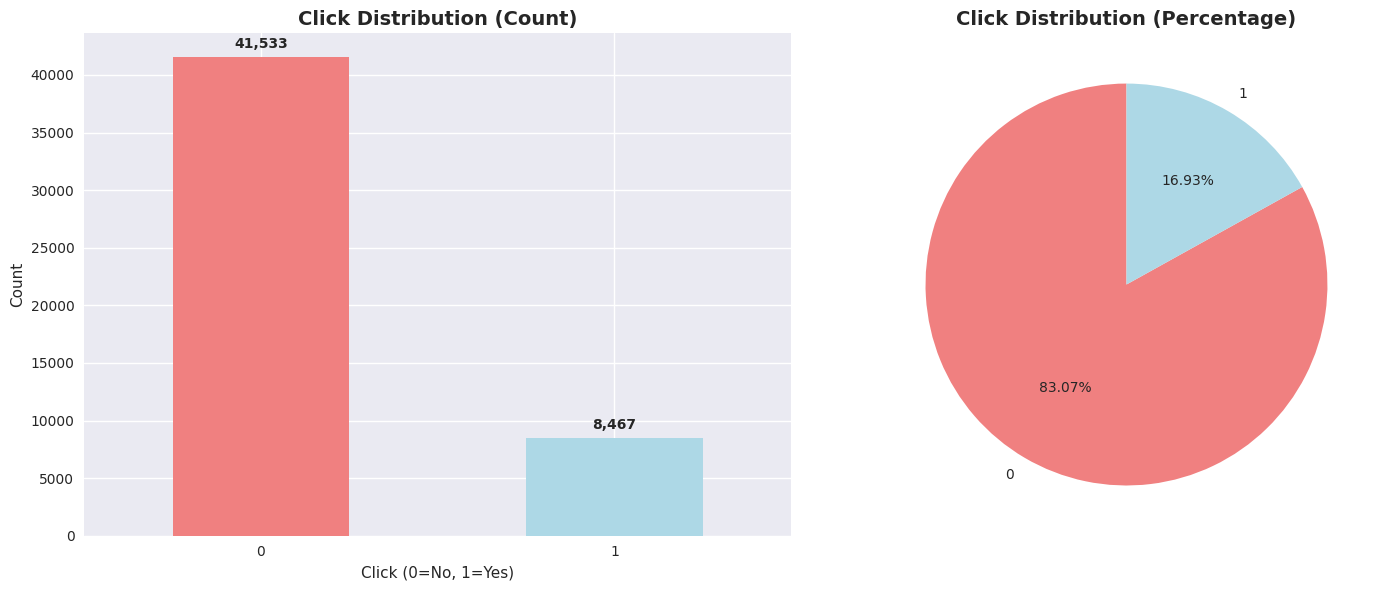

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

colors = ['lightcoral', 'lightblue']

click_counts.plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('Click Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Click (0=No, 1=Yes)')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

for i, v in enumerate(click_counts.values):
    axes[0].text(i, v + 500, f'{v:,}', ha='center', va='bottom', fontweight='bold')

click_counts.plot(kind='pie', ax=axes[1], autopct='%1.2f%%', colors=colors, startangle=90)
axes[1].set_title('Click Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

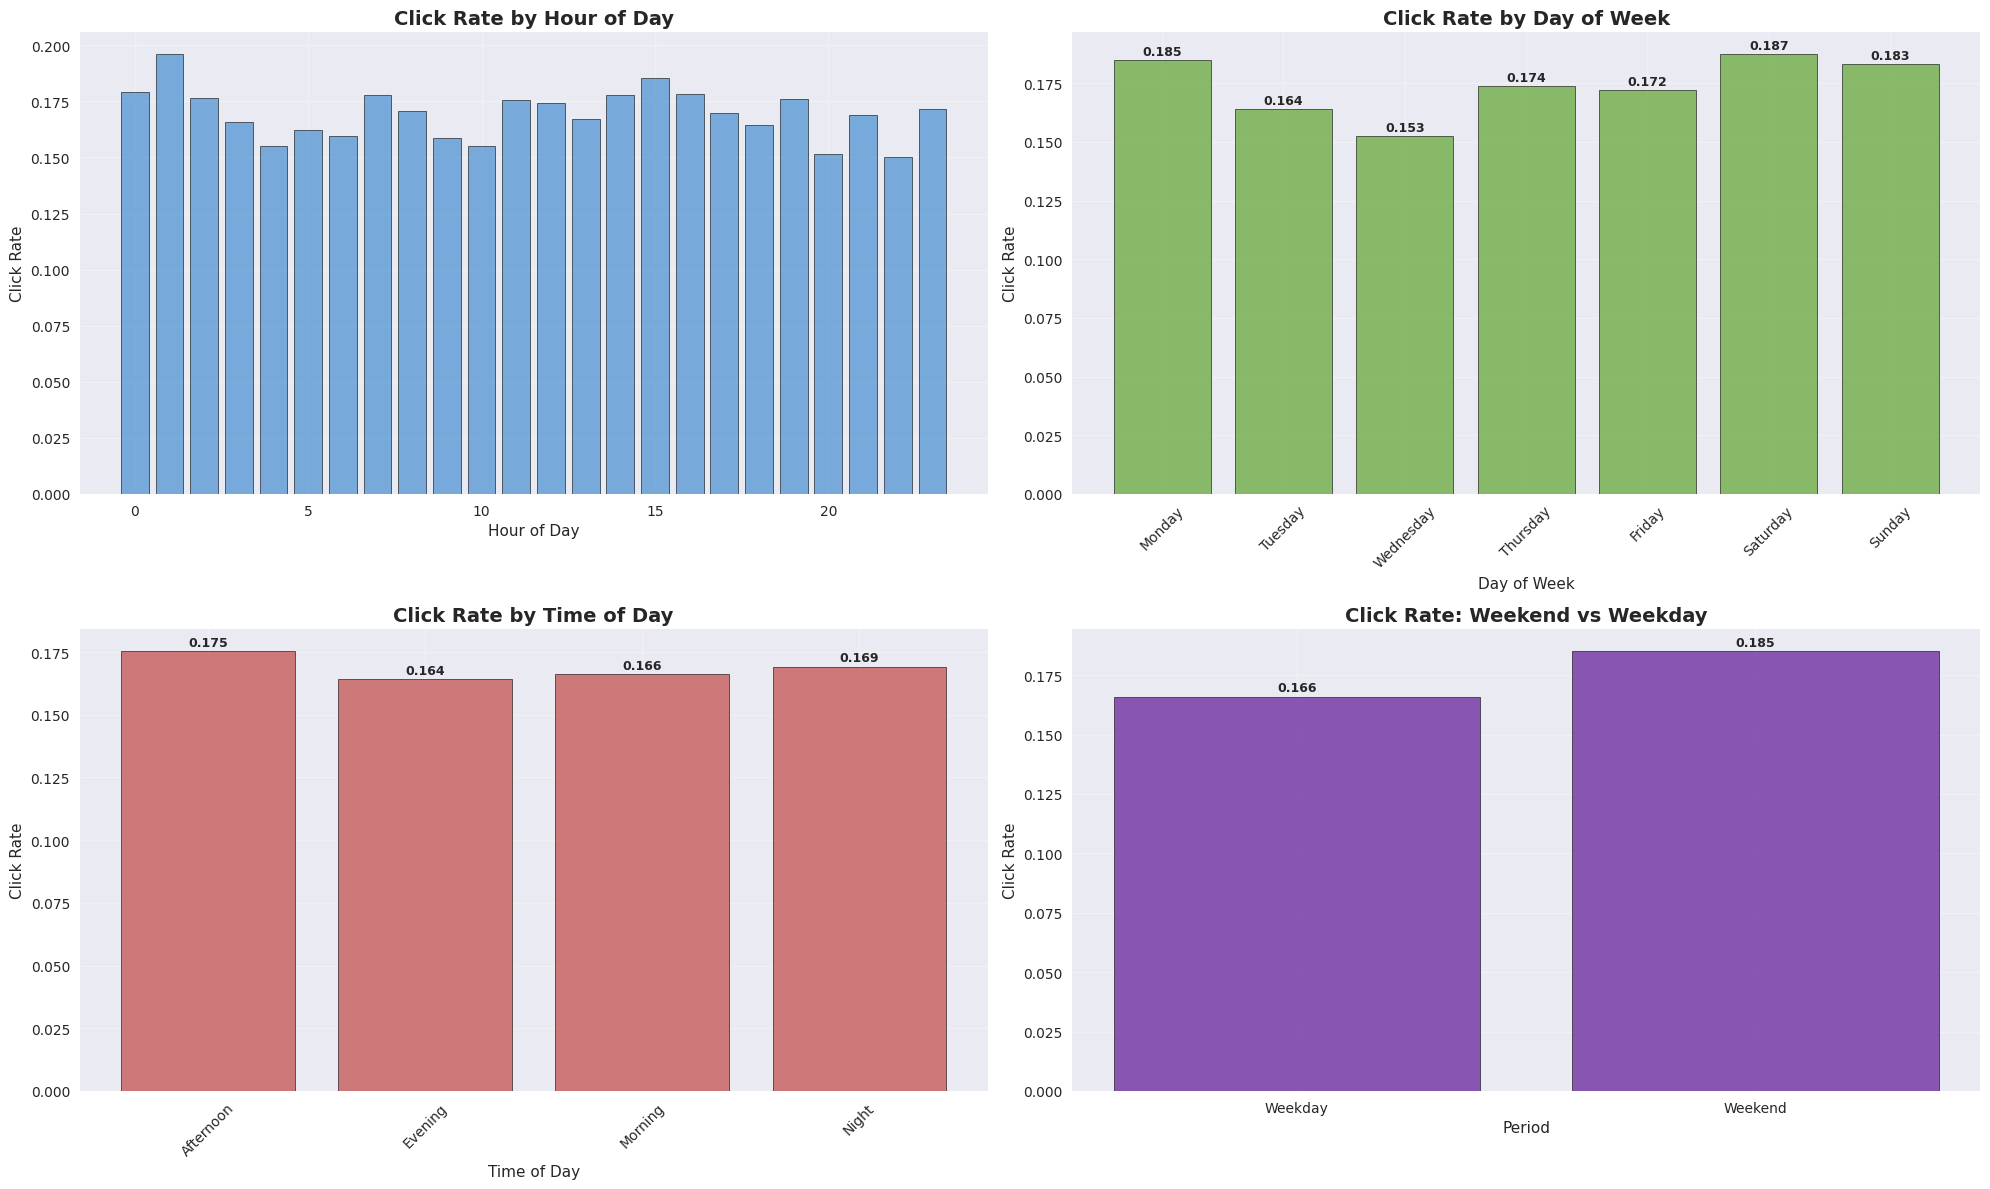

In [13]:
# Temporal analysis
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

colors = {'primary': '#5B9BD5', 'secondary': '#70AD47', 'tertiary': '#C55A5A', 'quaternary': '#7030A0'}

# 1. Click rate by hour of day
hourly_clicks = df_clean.groupby('hour_of_day')['click'].agg(['count', 'sum', 'mean']).reset_index()
hourly_clicks.columns = ['hour_of_day', 'total_ads', 'total_clicks', 'click_rate']

axes[0,0].bar(hourly_clicks['hour_of_day'], hourly_clicks['click_rate'], color=colors['primary'], alpha=0.8, edgecolor='black', linewidth=0.5)
axes[0,0].set_title('Click Rate by Hour of Day', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Click Rate')
axes[0,0].grid(True, alpha=0.3)

# 2. Click rate by day of week
daily_clicks = df_clean.groupby('day_of_week')['click'].agg(['count', 'sum', 'mean']).reset_index()
daily_clicks.columns = ['day_of_week', 'total_ads', 'total_clicks', 'click_rate']

# Reorder days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_clicks['day_of_week'] = pd.Categorical(daily_clicks['day_of_week'], categories=day_order, ordered=True)
daily_clicks = daily_clicks.sort_values('day_of_week')

axes[0,1].bar(range(len(daily_clicks)), daily_clicks['click_rate'], color=colors['secondary'], alpha=0.8, edgecolor='black', linewidth=0.5)
axes[0,1].set_title('Click Rate by Day of Week', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Click Rate')
axes[0,1].set_xticks(range(len(daily_clicks)))
axes[0,1].set_xticklabels(daily_clicks['day_of_week'], rotation=45)
axes[0,1].grid(True, alpha=0.3)

# 3. Click rate by time of day
time_clicks = df_clean.groupby('time_of_day')['click'].agg(['count', 'sum', 'mean']).reset_index()
time_clicks.columns = ['time_of_day', 'total_ads', 'total_clicks', 'click_rate']

axes[1,0].bar(time_clicks['time_of_day'], time_clicks['click_rate'], color=colors['tertiary'], alpha=0.8, edgecolor='black', linewidth=0.5)
axes[1,0].set_title('Click Rate by Time of Day', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Time of Day')
axes[1,0].set_ylabel('Click Rate')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 4. Weekend vs Weekday
weekend_clicks = df_clean.groupby('is_weekend')['click'].agg(['count', 'sum', 'mean']).reset_index()
weekend_clicks.columns = ['is_weekend', 'total_ads', 'total_clicks', 'click_rate']
weekend_clicks['period'] = weekend_clicks['is_weekend'].map({0: 'Weekday', 1: 'Weekend'})

axes[1,1].bar(weekend_clicks['period'], weekend_clicks['click_rate'], color=colors['quaternary'], alpha=0.8, edgecolor='black', linewidth=0.5)
axes[1,1].set_title('Click Rate: Weekend vs Weekday', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Period')
axes[1,1].set_ylabel('Click Rate')
axes[1,1].grid(True, alpha=0.3)

datasets = [time_clicks, weekend_clicks, daily_clicks]
subplot_axes = [axes[1,0], axes[1,1], axes[0,1]]

for ax, data in zip(subplot_axes, datasets):
    for i, v in enumerate(data['click_rate']):
        ax.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

In [14]:
print(f"TEMPORAL INSIGHTS:")
print(f"- Peak hour: {hourly_clicks.loc[hourly_clicks['click_rate'].idxmax(), 'hour_of_day']}:00 (CTR: {hourly_clicks['click_rate'].max():.4f})")
print(f"- Best day: {daily_clicks.loc[daily_clicks['click_rate'].idxmax(), 'day_of_week']} (CTR: {daily_clicks['click_rate'].max():.4f})")
print(f"- Best time period: {time_clicks.loc[time_clicks['click_rate'].idxmax(), 'time_of_day']} (CTR: {time_clicks['click_rate'].max():.4f})")
print(f"- Weekend vs Weekday: {'Weekend' if weekend_clicks.loc[1, 'click_rate'] > weekend_clicks.loc[0, 'click_rate'] else 'Weekday'} performs better")

TEMPORAL INSIGHTS:
- Peak hour: 1:00 (CTR: 0.1960)
- Best day: Saturday (CTR: 0.1873)
- Best time period: Afternoon (CTR: 0.1753)
- Weekend vs Weekday: Weekend performs better


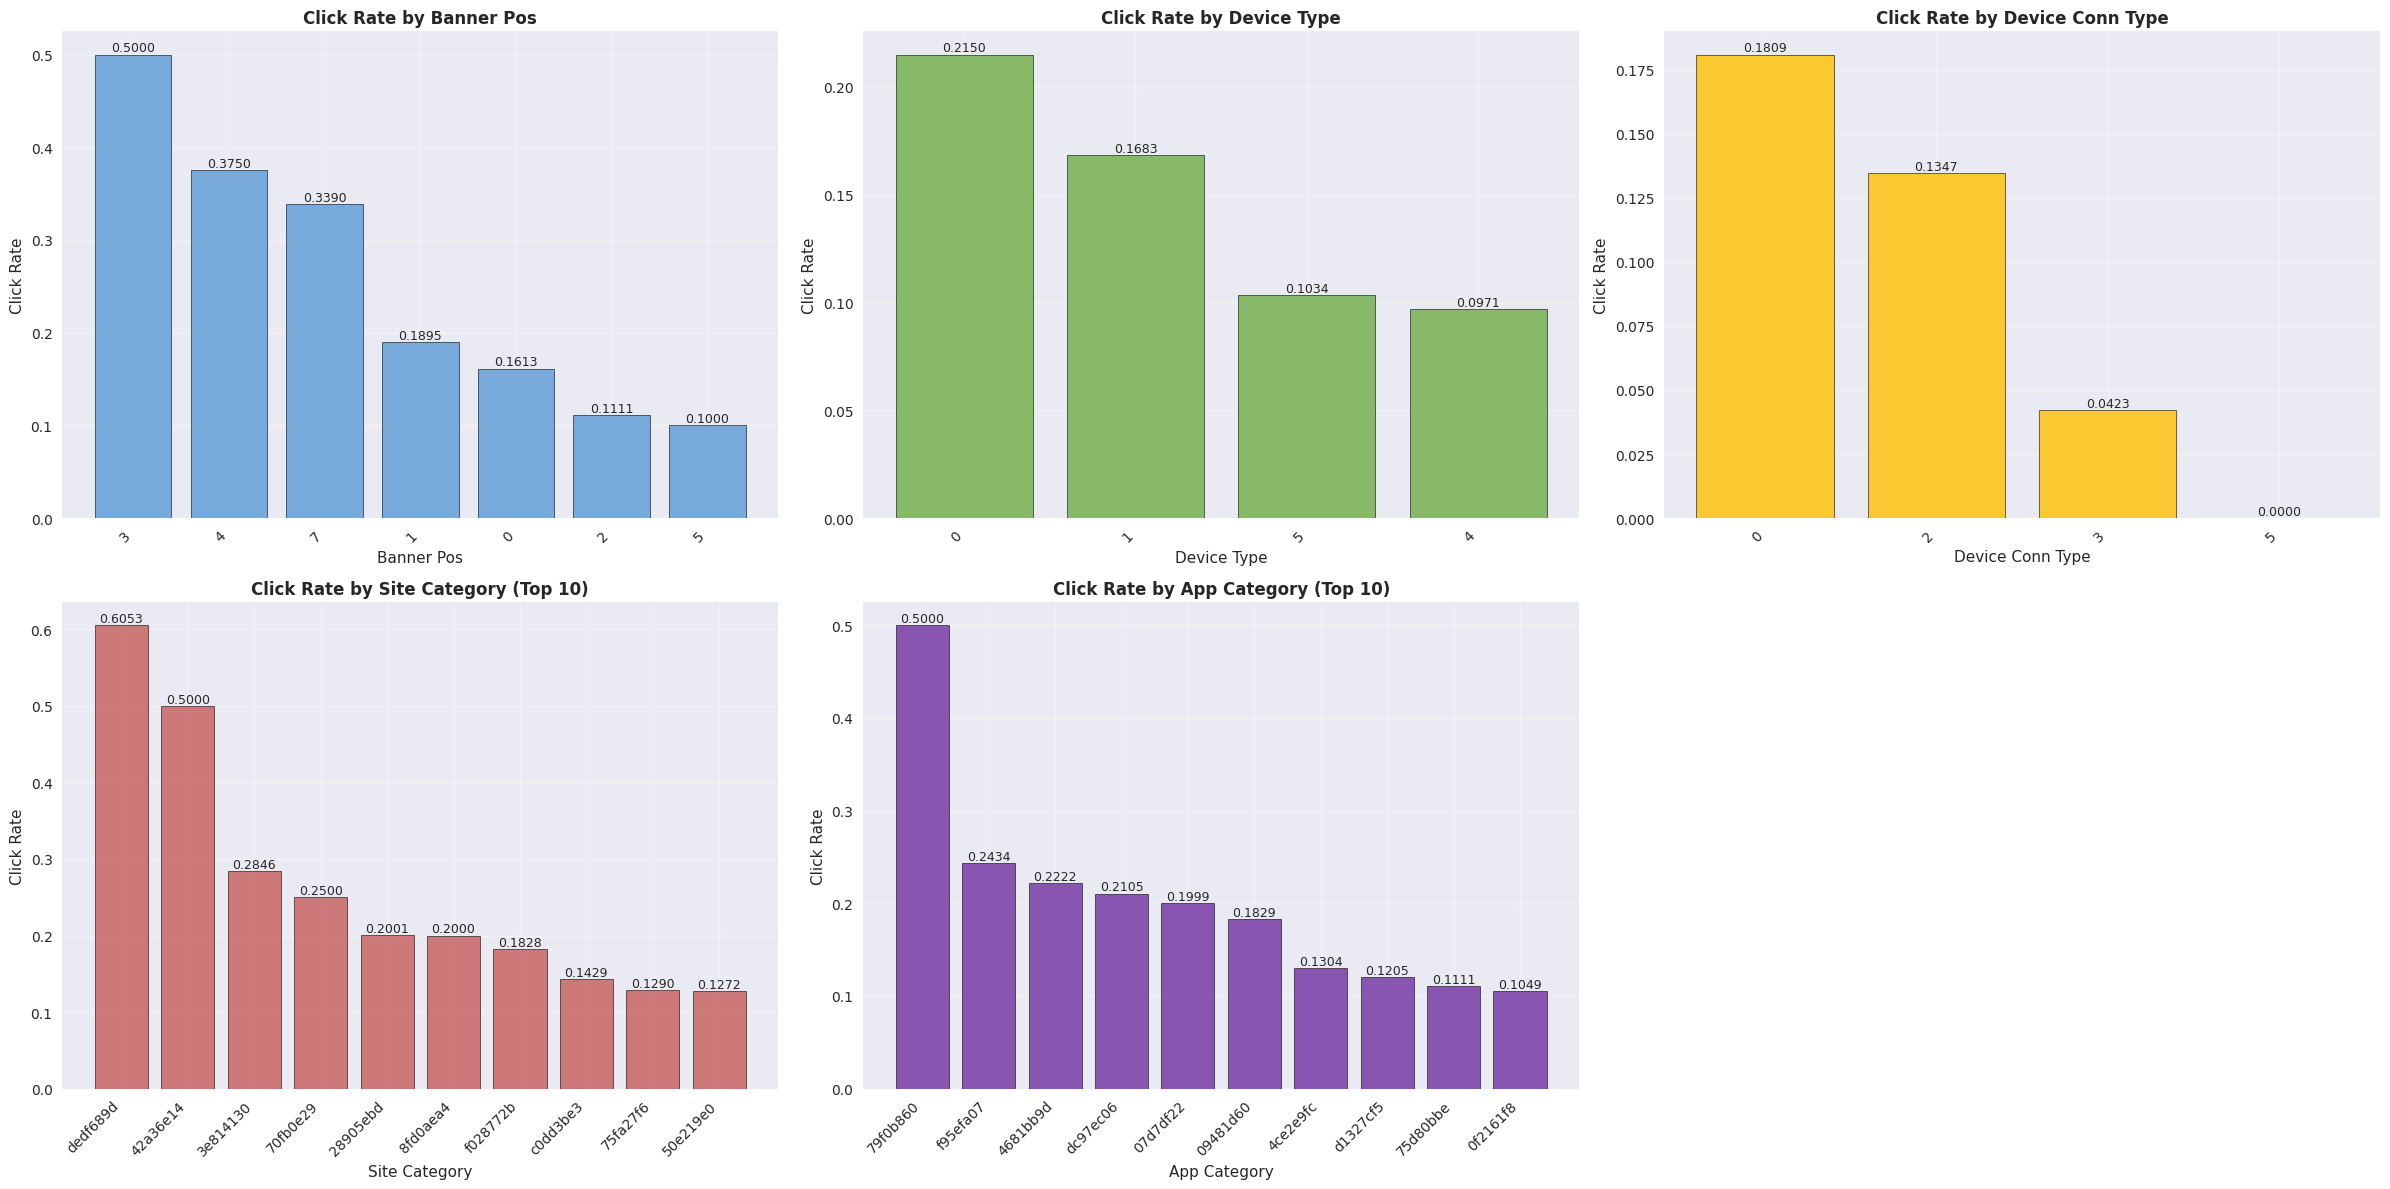

In [15]:
# Device and Categorical Features Analysis
categorical_features = ['banner_pos', 'device_type', 'device_conn_type', 'site_category', 'app_category']

fig, axes = plt.subplots(2, 3, figsize=(24, 12))
axes = axes.flatten()

colors = ['#5B9BD5', '#70AD47', '#FFC000', '#C55A5A', '#7030A0']

for i, feature in enumerate(categorical_features):
    if feature in df_clean.columns:
        feature_analysis = df_clean.groupby(feature)['click'].agg(['count', 'sum', 'mean']).reset_index()
        feature_analysis.columns = [feature, 'total_ads', 'total_clicks', 'click_rate']
        feature_analysis = feature_analysis.sort_values('click_rate', ascending=False)
        
        if len(feature_analysis) > 10:
            plot_data = feature_analysis.head(10)
            title_suffix = " (Top 10)"
        else:
            plot_data = feature_analysis
            title_suffix = ""
            
        bar_colors = [colors[i % len(colors)]] * len(plot_data)
        axes[i].bar(range(len(plot_data)), plot_data['click_rate'], color=bar_colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        axes[i].set_title(f'Click Rate by {feature.replace("_", " ").title()}{title_suffix}',  fontsize=12, fontweight='bold')
        axes[i].set_xlabel(feature.replace("_", " ").title())
        axes[i].set_ylabel('Click Rate')
        axes[i].set_xticks(range(len(plot_data)))
        axes[i].set_xticklabels(plot_data[feature], rotation=45, ha='right')
        axes[i].grid(True, alpha=0.3)
        
        for j, v in enumerate(plot_data['click_rate']):
            axes[i].text(j, v + 0.0001, f'{v:.4f}', ha='center', va='bottom', fontsize=9)
        
if len(categorical_features) < 6:
    axes[5].remove()

plt.tight_layout()
plt.show()

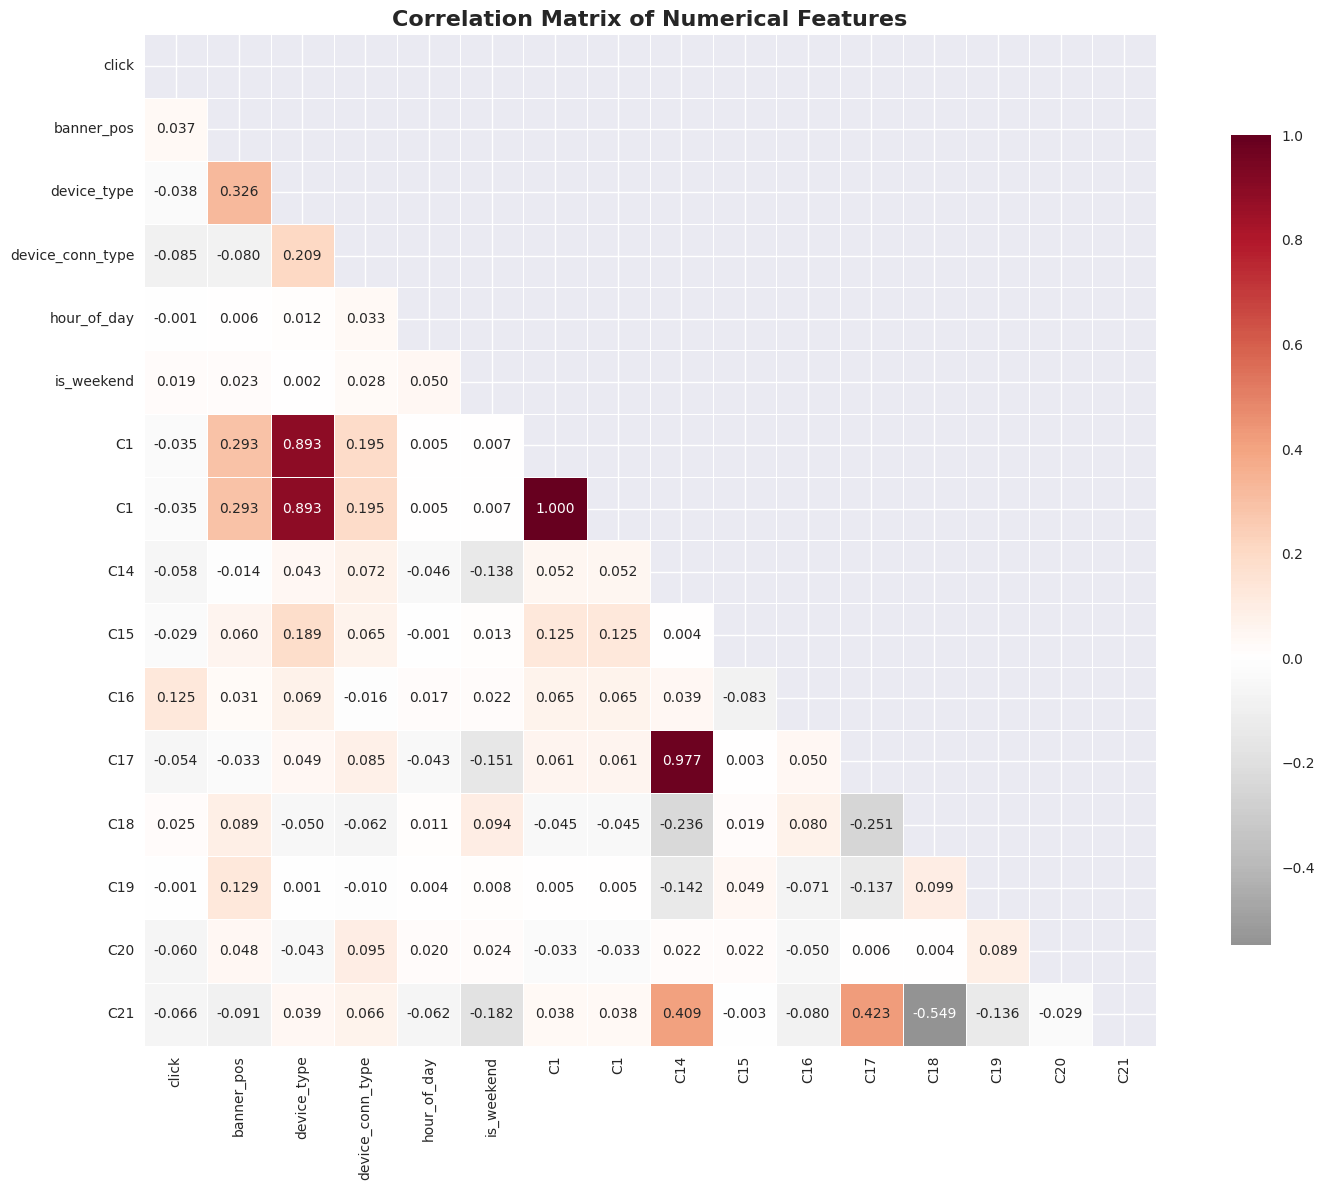

In [16]:
# Correlation Analysis
numerical_features = ['click', 'banner_pos', 'device_type', 'device_conn_type', 'hour_of_day', 'is_weekend', 'C1'] + [col for col in df_clean.columns if col.startswith('C') and col[1:].isdigit()]

corr_data = df_clean[numerical_features].corr()

plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(corr_data, dtype=bool)) 

sns.heatmap(corr_data, annot=True, cmap='RdGy_r', center=0, 
            square=True, fmt='.3f', cbar_kws={"shrink": .8}, mask=mask,
            linewidths=0.5, linecolor='white')
plt.title('Correlation Matrix of Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [17]:
# Outlier detection
numerical_cols = ['banner_pos', 'device_type', 'device_conn_type', 'hour_of_day'] + [col for col in df_clean.columns if col.startswith('C') and col[1:].isdigit()]

outlier_summary = []
for col in numerical_cols:
    if col in df_clean.columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(df_clean)) * 100
        
        outlier_summary.append({
            'Feature': col,
            'Outlier_Count': outlier_count,
            'Outlier_Percentage': outlier_percentage,
            'Lower_Bound': lower_bound,
            'Upper_Bound': upper_bound
        })

outlier_df = pd.DataFrame(outlier_summary)
outlier_df = outlier_df.sort_values('Outlier_Percentage', ascending=False)

print("Outlier Summary (using IQR method):")
display(outlier_df.head(10))

Outlier Summary (using IQR method):


,Feature,Outlier_Count,Outlier_Percentage,Lower_Bound,Upper_Bound
10,C19,8908,17.816,-169.0,375.0
12,C21,7117,14.234,-94.0,218.0
2,device_conn_type,6927,13.854,0.0,0.0
8,C17,4248,8.496,871.5,3515.5
5,C14,4182,8.364,9475.5,29327.5
4,C1,4029,8.058,1005.0,1005.0
1,device_type,3831,7.662,1.0,1.0
6,C15,3400,6.800,320.0,320.0
7,C16,2887,5.774,50.0,50.0
0,banner_pos,79,0.158,-1.5,2.5


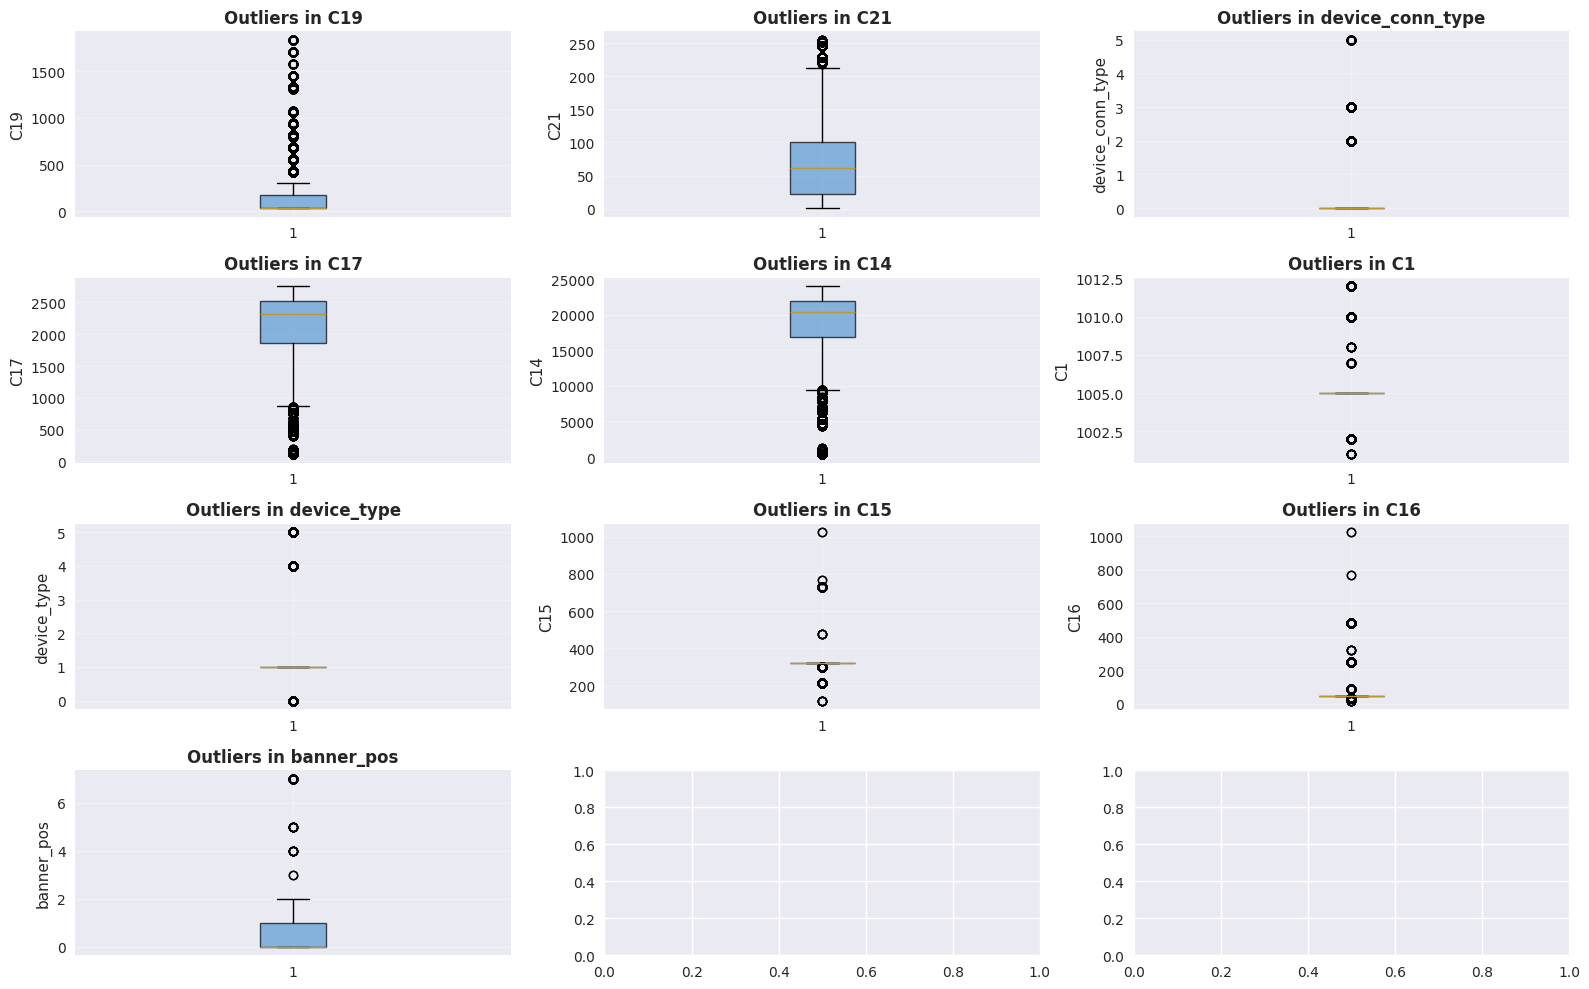

In [18]:
features_with_outliers = outlier_df[outlier_df['Outlier_Percentage'] > 0]['Feature']

fig, axes = plt.subplots(4, 3, figsize=(16, 10))
axes = axes.flatten()

for i, feature in enumerate(features_with_outliers):
    bp = axes[i].boxplot(df_clean[feature], patch_artist=True)
    bp['boxes'][0].set_facecolor('#5B9BD5')
    bp['boxes'][0].set_alpha(0.7)
    axes[i].set_title(f'Outliers in {feature}', fontweight='bold')
    axes[i].set_ylabel(feature)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# Interactive time series plot
daily_trends = df_clean.groupby(df_clean['hour'].dt.date)['click'].agg(['count', 'sum', 'mean']).reset_index()
daily_trends.columns = ['date', 'total_ads', 'total_clicks', 'click_rate']

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=daily_trends['date'], 
    y=daily_trends['click_rate'],
    mode='lines+markers',
    name='Click Rate',
    line=dict(color='#2E86AB', width=2),
    marker=dict(size=4, color='#2E86AB')
))

fig.update_layout(
    title='Daily Click Rate Trend Over Time',
    xaxis_title='Date',
    yaxis_title='Click Rate',
    hovermode='x unified',
    template='plotly_white',
    showlegend=False,
    plot_bgcolor='white'
)

fig.show()

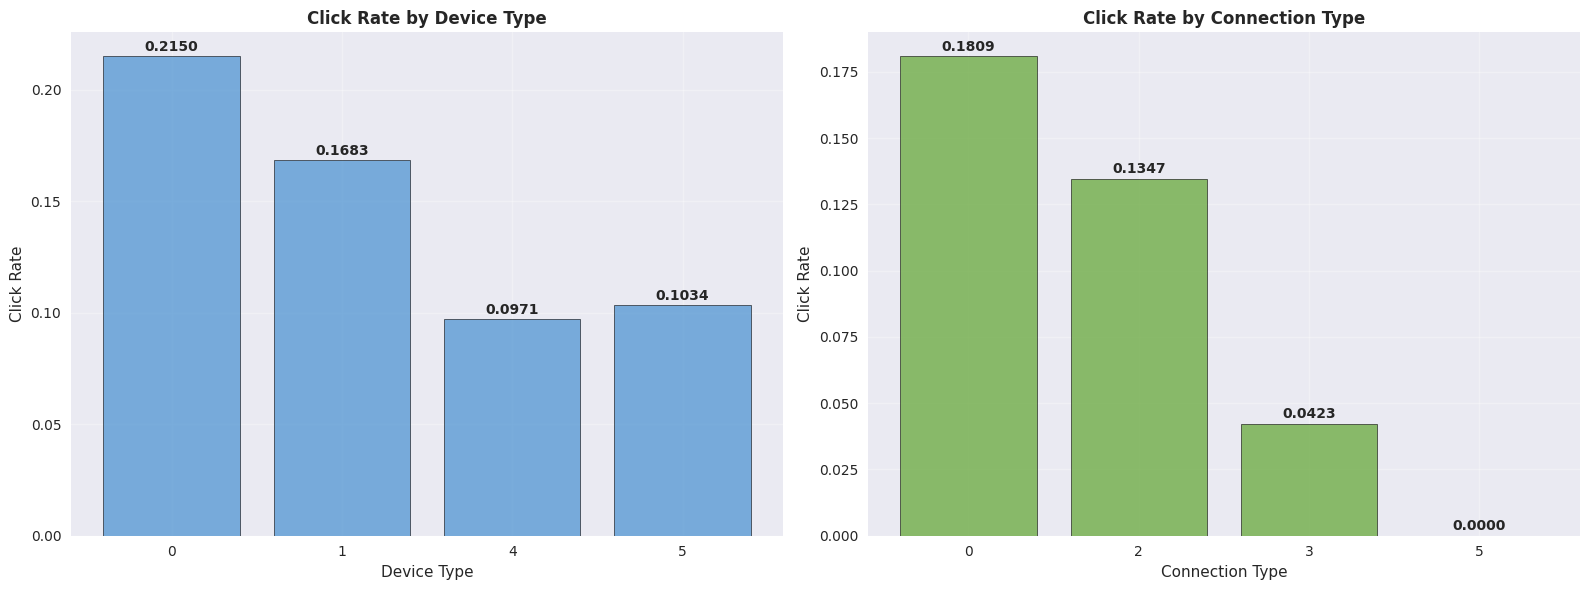

In [20]:
# Device Type vs Connection Type Analysis
device_conn_analysis = df_clean.groupby(['device_type', 'device_conn_type'])['click'].agg(['count', 'mean']).reset_index()
device_conn_analysis.columns = ['device_type', 'device_conn_type', 'count', 'click_rate']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Device type click rates
device_summary = df_clean.groupby('device_type')['click'].agg(['count', 'mean']).reset_index()
device_summary.columns = ['device_type', 'total_ads', 'click_rate']

ax1.bar(device_summary['device_type'].astype(str), device_summary['click_rate'], 
        color='#5B9BD5', alpha=0.8, edgecolor='black', linewidth=0.5)
ax1.set_title('Click Rate by Device Type', fontweight='bold')
ax1.set_xlabel('Device Type')
ax1.set_ylabel('Click Rate')
ax1.grid(True, alpha=0.3)

for i, v in enumerate(device_summary['click_rate']):
    ax1.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# Connection type click rates
conn_summary = df_clean.groupby('device_conn_type')['click'].agg(['count', 'mean']).reset_index()
conn_summary.columns = ['device_conn_type', 'total_ads', 'click_rate']

ax2.bar(conn_summary['device_conn_type'].astype(str), conn_summary['click_rate'], 
        color='#70AD47', alpha=0.8, edgecolor='black', linewidth=0.5)
ax2.set_title('Click Rate by Connection Type', fontweight='bold')
ax2.set_xlabel('Connection Type')
ax2.set_ylabel('Click Rate')
ax2.grid(True, alpha=0.3)

for i, v in enumerate(conn_summary['click_rate']):
    ax2.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [21]:
# Click Rate by Hour and Banner Position
fig = go.Figure()

hour_banner_analysis = df_clean.groupby(['hour_of_day', 'banner_pos'])['click'].agg(['count', 'mean']).reset_index()
hour_banner_analysis.columns = ['hour_of_day', 'banner_pos', 'ad_count', 'click_rate']

min_ads = 50
filtered_data = hour_banner_analysis[hour_banner_analysis['ad_count'] >= min_ads]

fig.add_trace(go.Scatter(
    x=filtered_data['hour_of_day'],
    y=filtered_data['click_rate'],
    mode='markers',
    marker=dict(
        size=filtered_data['ad_count']/50,  
        color='#5B9BD5', 
        opacity=0.7,
        line=dict(width=1, color='black')
    ),
    text=[f'Hour: {h}<br>Banner Pos: {b}<br>Click Rate: {cr:.4f}<br>Ads: {ac}' 
          for h, b, cr, ac in zip(filtered_data['hour_of_day'], filtered_data['banner_pos'], 
                                 filtered_data['click_rate'], filtered_data['ad_count'])],
    hovertemplate='%{text}<extra></extra>',
    name='Click Rate by Hour'
))

fig.update_layout(
    title='Click Rate Distribution by Hour of Day',
    xaxis_title='Hour of Day',
    yaxis_title='Click Rate',
    template='plotly_white',
    showlegend=False,
    plot_bgcolor='white'
)

fig.show()

## 4. Baseline Model

### Feature Engineering

In [22]:
# Select features for modeling
feature_columns = [
    'banner_pos', 'device_type', 'device_conn_type',
    'hour_of_day', 'is_weekend', 'time_of_day',
    'site_category', 'app_category'
] + [col for col in df_clean.columns if col.startswith('C') and col[1:].isdigit()]

print(f"Selected {len(feature_columns)} features for modeling:")
for i, feature in enumerate(feature_columns, 1):
    print(f"{i:2d}. {feature}")

Selected 17 features for modeling:
 1. banner_pos
 2. device_type
 3. device_conn_type
 4. hour_of_day
 5. is_weekend
 6. time_of_day
 7. site_category
 8. app_category
 9. C1
10. C14
11. C15
12. C16
13. C17
14. C18
15. C19
16. C20
17. C21


In [23]:
# Prepare the dataset for modeling
X = df_clean[feature_columns].copy()
y = df_clean['click'].copy()

print(f"\nModel dataset shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")


Model dataset shape: (50000, 17)
Target distribution: {0: 41533, 1: 8467}


In [24]:
# Handle categorical variables using One-Hot Encoding
categorical_columns = ['time_of_day', 'site_category', 'app_category']
categorical_columns = [col for col in categorical_columns if col in X.columns]

print("Applying One-Hot Encoding to categorical features:")
print("=" * 80)

# Get one-hot encoded features
X_encoded = pd.get_dummies(X, columns=categorical_columns, prefix=categorical_columns, drop_first=True)

print(f"Original features: {X.shape[1]}")
print(f"After one-hot encoding: {X_encoded.shape[1]}")
print(f"Added {X_encoded.shape[1] - X.shape[1]} binary features")
print("\nEncoded columns for each categorical feature:")
for col in categorical_columns:
    encoded_cols = [c for c in X_encoded.columns if c.startswith(f"{col}_")]
    print(f"  {col}: {len(encoded_cols)} binary columns")
    
# Update X with encoded features
X = X_encoded.copy()
print("=" * 80)

Applying One-Hot Encoding to categorical features:
Original features: 17
After one-hot encoding: 52
Added 35 binary features

Encoded columns for each categorical feature:
  time_of_day: 3 binary columns
  site_category: 17 binary columns
  app_category: 18 binary columns


In [25]:
print(f"Feature preparation completed. Final shape: {X.shape}")
print(f"Data types: {X.dtypes.value_counts().to_dict()}")

Feature preparation completed. Final shape: (50000, 52)
Data types: {dtype('bool'): 38, dtype('int64'): 13, dtype('int32'): 1}


### Chronological Train-Test Split

In [26]:
# Sort data by timestamp for chronological split
df_sorted = df_clean.sort_values('hour').reset_index(drop=True)

# Get feature columns from one-hot encoded X
feature_columns_encoded = X.columns.tolist()
X_sorted = df_sorted[X.columns.intersection(df_sorted.columns)].copy()

# Identify categorical columns present in the sorted dataframe
categorical_columns_temp = ['time_of_day', 'site_category', 'app_category']
categorical_columns_temp = [col for col in categorical_columns_temp if col in df_sorted.columns]

# Recreate the full feature set with proper one-hot encoding
X_sorted_base = df_sorted[[col for col in feature_columns if col in df_sorted.columns and col not in categorical_columns_temp]].copy()
X_sorted_encoded = pd.get_dummies(df_sorted[categorical_columns_temp], columns=categorical_columns_temp, 
                                   prefix=categorical_columns_temp, drop_first=True)
X_sorted = pd.concat([X_sorted_base, X_sorted_encoded], axis=1)

# Ensure column alignment with training feature set
X_sorted = X_sorted.reindex(columns=X.columns, fill_value=0)

y_sorted = df_sorted['click'].copy()

# Use 80-20 chronological split
split_index = int(len(X_sorted) * 0.8)

X_train = X_sorted[:split_index].copy()
X_test = X_sorted[split_index:].copy()
y_train = y_sorted[:split_index].copy()
y_test = y_sorted[split_index:].copy()

print("Chronological Train-Test Split:")
print("=" * 80)
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set time range: {df_sorted.loc[:split_index-1, 'hour'].min()} to {df_sorted.loc[:split_index-1, 'hour'].max()}")
print(f"Test set time range: {df_sorted.loc[split_index:, 'hour'].min()} to {df_sorted.loc[split_index:, 'hour'].max()}")
print(f"\nTraining set class distribution: {y_train.value_counts().to_dict()}")
print(f"Test set class distribution: {y_test.value_counts().to_dict()}")
print(f"\nTraining CTR: {y_train.mean():.4f} ({y_train.mean()*100:.2f}%)")
print(f"Test CTR: {y_test.mean():.4f} ({y_test.mean()*100:.2f}%)")
print("=" * 80)

Chronological Train-Test Split:
Training set shape: (40000, 52)
Test set shape: (10000, 52)

Training set time range: 2014-10-21 00:00:00 to 2014-10-28 23:00:00
Test set time range: 2014-10-28 23:00:00 to 2014-10-30 23:00:00

Training set class distribution: {0: 33120, 1: 6880}
Test set class distribution: {0: 8413, 1: 1587}

Training CTR: 0.1720 (17.20%)
Test CTR: 0.1587 (15.87%)


### Baseline Model: Random Forest

In [27]:
# Train Random Forest Classifier
print(f"Training Random Forest Classifier")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Random Forest ROC-AUC: {roc_auc:.4f}")

Training Random Forest Classifier
Random Forest ROC-AUC: 0.6626


In [28]:
# Train a Logistic Regression as comparison
print(f"Training Logistic Regression")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

print(f"Logistic Regression ROC-AUC: {roc_auc_lr:.4f}")

Training Logistic Regression
Logistic Regression ROC-AUC: 0.6437


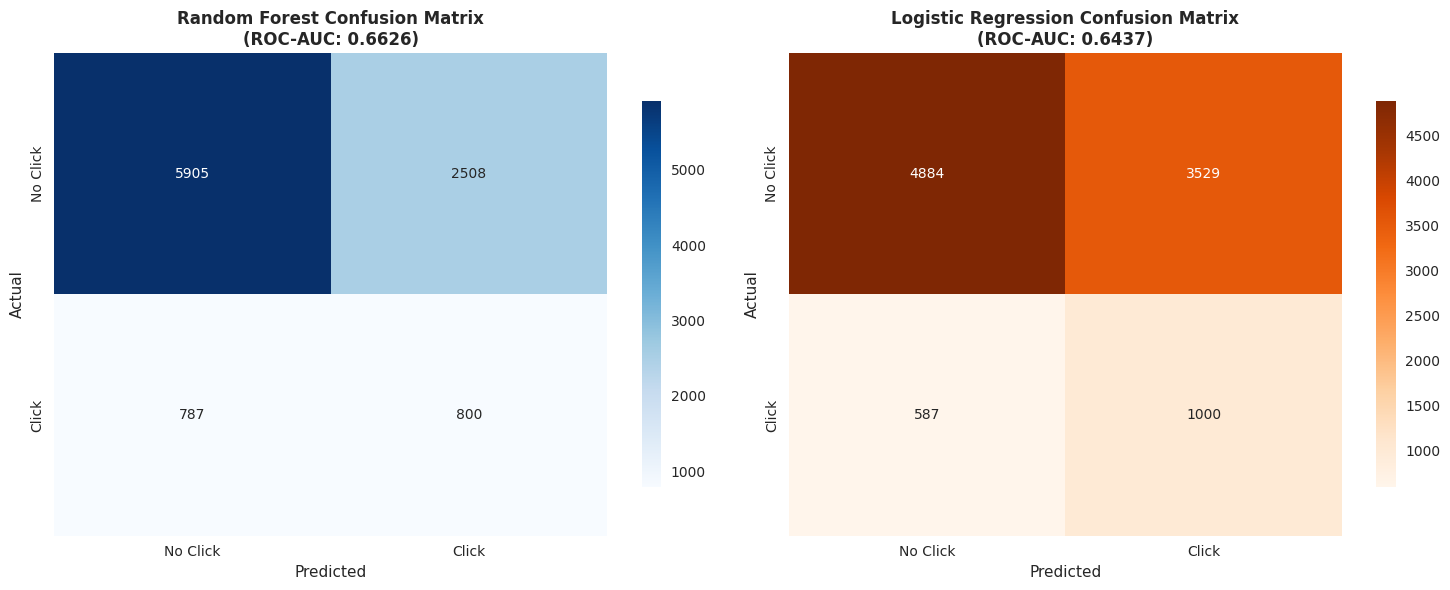

In [29]:
# Plot Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Click', 'Click'], yticklabels=['No Click', 'Click'],
            cbar_kws={'shrink': 0.8})
axes[0].set_title(f'Random Forest Confusion Matrix\n(ROC-AUC: {roc_auc:.4f})', fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['No Click', 'Click'], yticklabels=['No Click', 'Click'],
            cbar_kws={'shrink': 0.8})
axes[1].set_title(f'Logistic Regression Confusion Matrix\n(ROC-AUC: {roc_auc_lr:.4f})', fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [30]:
def calculate_metrics(cm, model_name, roc_auc_score):
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'Model': model_name,
        'Accuracy': f"{accuracy:.4f}",
        'Precision': f"{precision:.4f}",
        'Recall': f"{recall:.4f}",
        'F1-Score': f"{f1:.4f}",
        'ROC-AUC': f"{roc_auc_score:.4f}"
    }

rf_metrics = calculate_metrics(cm_rf, "Random Forest", roc_auc)
lr_metrics = calculate_metrics(cm_lr, "Logistic Regression", roc_auc_lr)

performance_df = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression'],
    'Accuracy': [f"{rf_metrics['Accuracy']}", f"{lr_metrics['Accuracy']}"],
    'Precision': [f"{rf_metrics['Precision']}", f"{lr_metrics['Precision']}"],
    'Recall': [f"{rf_metrics['Recall']}", f"{lr_metrics['Recall']}"],
    'F1-Score': [f"{rf_metrics['F1-Score']}", f"{lr_metrics['F1-Score']}"],
    'ROC-AUC': [f"{rf_metrics['ROC-AUC']}", f"{lr_metrics['ROC-AUC']}"]
})
display(performance_df.set_index('Model'))

,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Model,,,,,
Random Forest,0.6705,0.2418,0.5041,0.3269,0.6626
Logistic Regression,0.5884,0.2208,0.6301,0.3270,0.6437


### Feature Importance and Model Interpretation

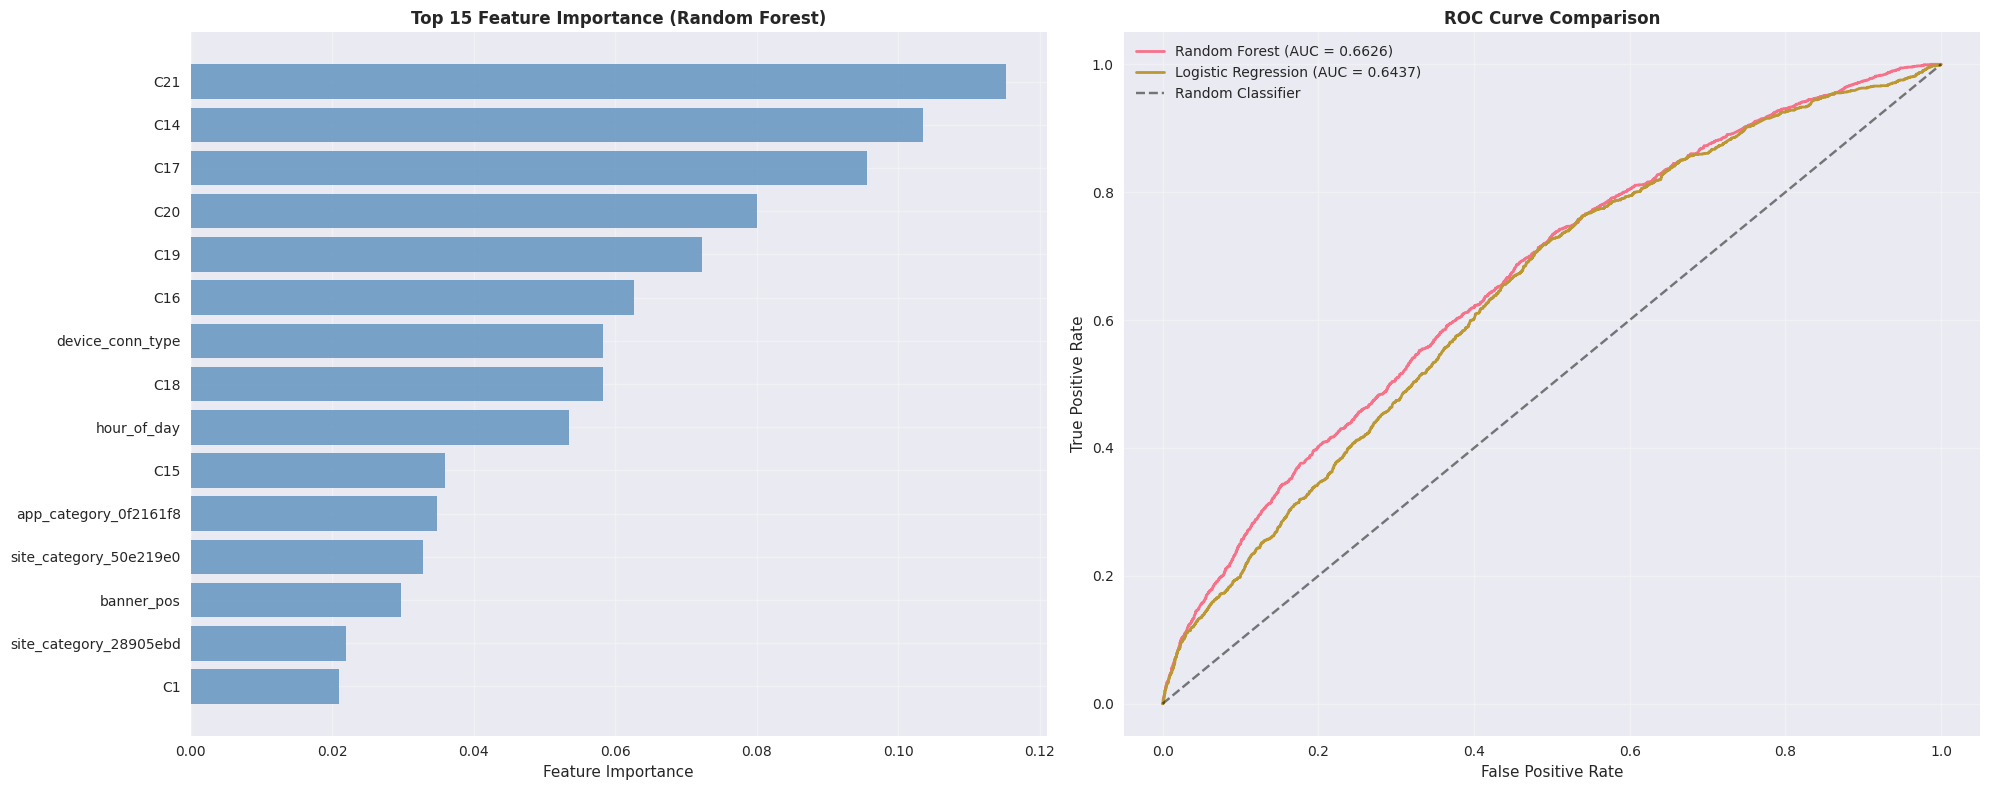

In [31]:
# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot feature importance
top_features = feature_importance.head(15)
axes[0].barh(range(len(top_features), 0, -1), top_features['importance'], color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(top_features), 0, -1))
axes[0].set_yticklabels(top_features['feature'])
axes[0].set_xlabel('Feature Importance')
axes[0].set_title('Top 15 Feature Importance (Random Forest)', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)

axes[1].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc:.4f})', linewidth=2)
axes[1].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve Comparison', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


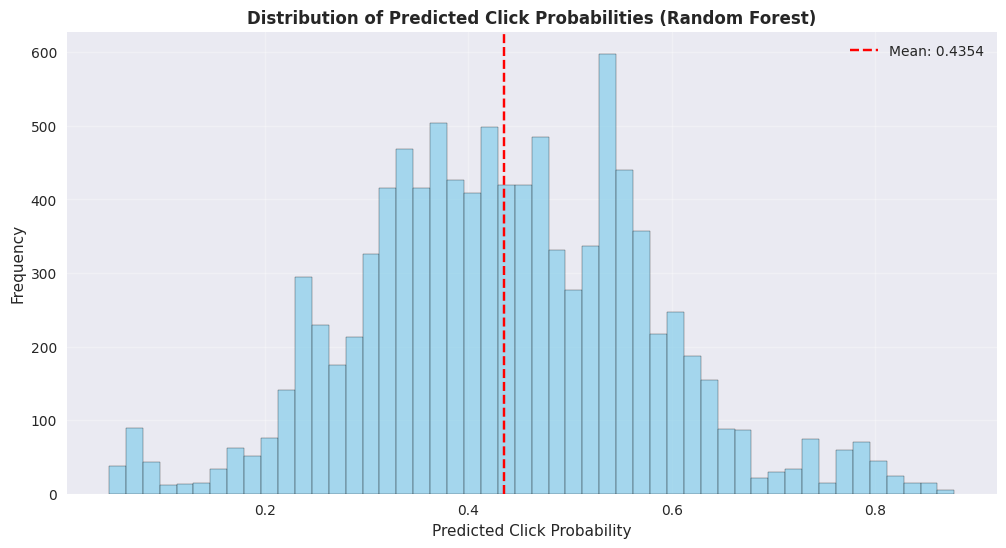

In [32]:
# Plot probability distribution
plt.figure(figsize=(12, 6))
plt.hist(y_pred_proba, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Predicted Click Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Click Probabilities (Random Forest)', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axvline(y_pred_proba.mean(), color='red', linestyle='--', label=f'Mean: {y_pred_proba.mean():.4f}')
plt.legend()
plt.show()

### Permutation Importance

In [33]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance for Random Forest
print("Calculating Permutation Importance for Random Forest")
print("=" * 80)

perm_importance_rf = permutation_importance(
    rf_model, X_test, y_test, 
    n_repeats=10,
    random_state=42,
    scoring='roc_auc',
    n_jobs=-1
)

# Create DataFrame for permutation importance
perm_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm_importance_rf.importances_mean,
    'importance_std': perm_importance_rf.importances_std
}).sort_values('importance_mean', ascending=False)

print(f"Top 15 Features by Permutation Importance:")
print(perm_importance_df.head(15).to_string(index=False))
print("=" * 80)

Calculating Permutation Importance for Random Forest
Top 15 Features by Permutation Importance:
               feature  importance_mean  importance_std
                   C21         0.017889        0.002067
                   C20         0.009183        0.002600
                   C18         0.008485        0.001593
            banner_pos         0.006731        0.002146
                   C19         0.005739        0.001218
site_category_f028772b         0.005438        0.000859
                   C14         0.005171        0.001478
 app_category_f95efa07         0.004120        0.000221
                   C16         0.003713        0.000685
      device_conn_type         0.003471        0.001265
                   C17         0.003462        0.001328
                    C1         0.002779        0.000515
 app_category_0f2161f8         0.002678        0.000793
 app_category_cef3e649         0.002395        0.001015
 app_category_8ded1f7a         0.002284        0.000513


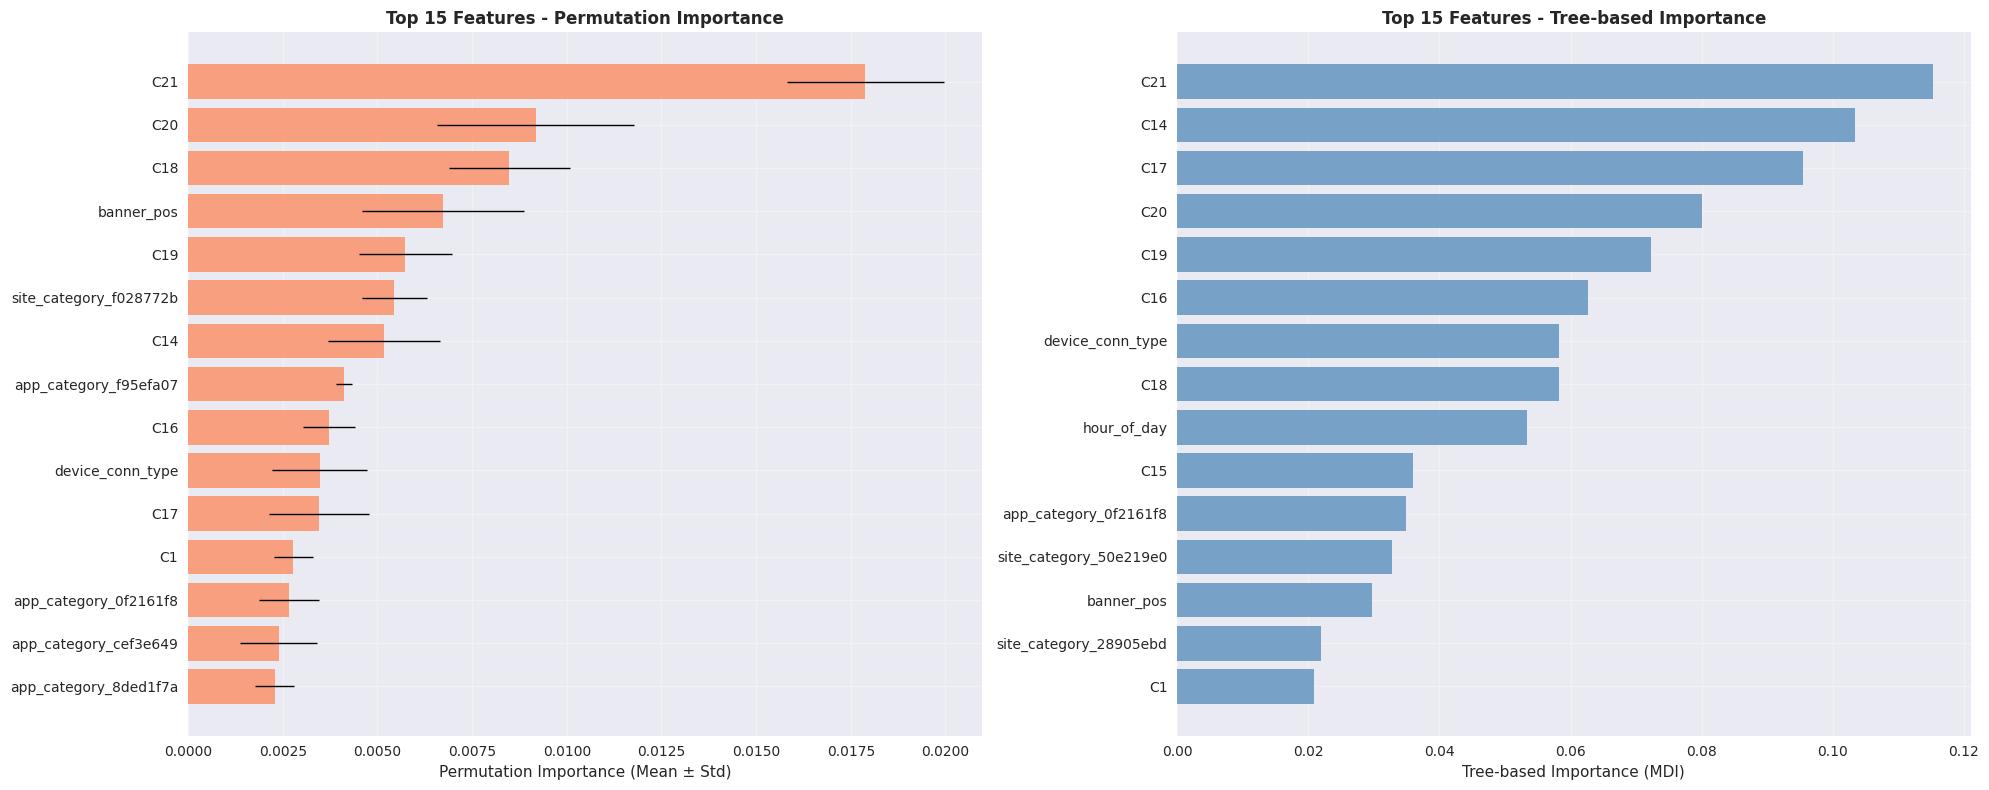

In [34]:
# Compare tree-based vs permutation importance
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Permutation Importance
top_perm = perm_importance_df.head(15)
axes[0].barh(range(len(top_perm), 0, -1), top_perm['importance_mean'], xerr=top_perm['importance_std'], color='coral', alpha=0.7,  error_kw={'elinewidth': 1, 'capsize': 3})
axes[0].set_yticks(range(len(top_perm), 0, -1))
axes[0].set_yticklabels(top_perm['feature'])
axes[0].set_xlabel('Permutation Importance (Mean ± Std)')
axes[0].set_title('Top 15 Features - Permutation Importance', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Tree-based Importance
top_tree = feature_importance.head(15)
axes[1].barh(range(len(top_tree), 0, -1), top_tree['importance'], color='steelblue', alpha=0.7)
axes[1].set_yticks(range(len(top_tree), 0, -1))
axes[1].set_yticklabels(top_tree['feature'])
axes[1].set_xlabel('Tree-based Importance (MDI)')
axes[1].set_title('Top 15 Features - Tree-based Importance', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### SHAP (SHapley Additive exPlanations) Analysis

In [35]:
import shap

# Initialize SHAP explainer
print("Initializing SHAP TreeExplainer for Random Forest...")
print("=" * 80)

explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for test set
sample_size = min(1000, len(X_test))
X_test_sample = X_test.sample(n=sample_size, random_state=42)

print(f"Calculating SHAP values for {sample_size} test samples...")
shap_values = explainer.shap_values(X_test_sample)

if isinstance(shap_values, list):
    shap_values_click = shap_values[1]
else:
    shap_values_click = shap_values

print(f"SHAP values shape: {shap_values_click.shape}")
print("=" * 80)

Initializing SHAP TreeExplainer for Random Forest...
Calculating SHAP values for 1000 test samples...
SHAP values shape: (1000, 52, 2)


SHAP values shape: (1000, 52)
Expected: (1000 samples, 52 features)


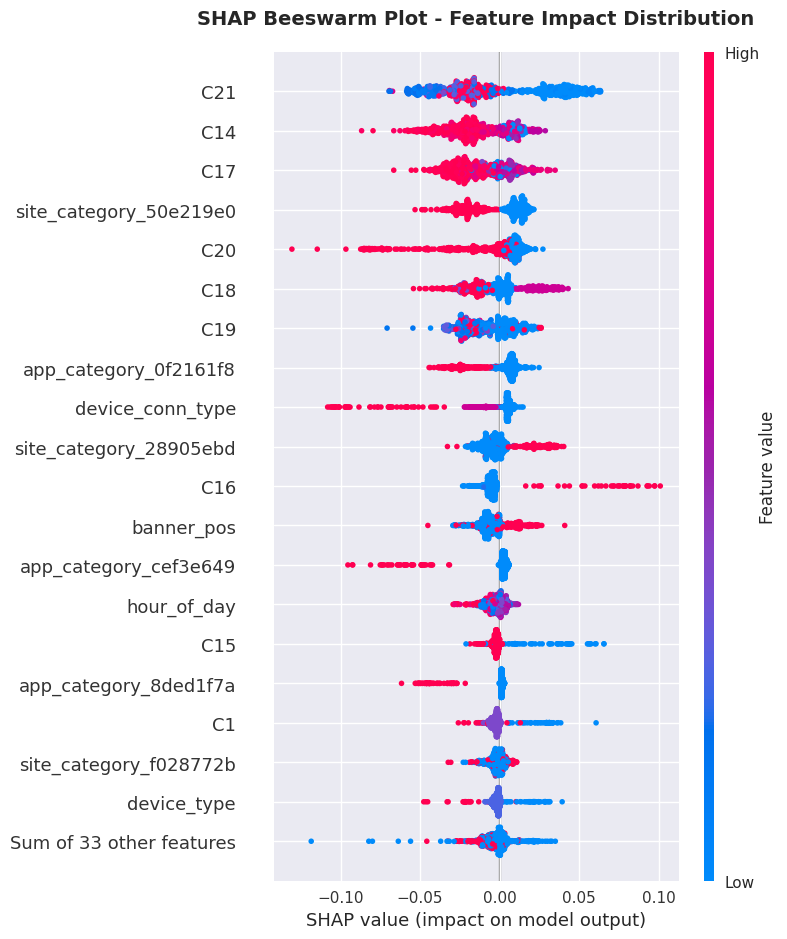

In [36]:
# Handle expected value
base_val = explainer.expected_value
if isinstance(base_val, (list, np.ndarray)):
    base_val = base_val[1]  # Use positive class for binary classification

# Ensure shap_values_click is 2D
if len(shap_values_click.shape) > 2:
    shap_vals_2d = shap_values_click[:, :, 1]
else:
    shap_vals_2d = shap_values_click

print(f"SHAP values shape: {shap_vals_2d.shape}")
print(f"Expected: ({len(X_test_sample)} samples, {len(X_test_sample.columns)} features)")

# Create SHAP Explanation object
shap_explanation = shap.Explanation(
    values=shap_vals_2d,
    base_values=base_val,
    data=X_test_sample.values,
    feature_names=X_test_sample.columns.tolist(),
)

# Create beeswarm plot
plt.figure(figsize=(12, 10))
shap.plots.beeswarm(shap_explanation, max_display=20, show=False)
plt.title('SHAP Beeswarm Plot - Feature Impact Distribution', fontweight='bold', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [37]:
# Compare all three feature importance methods
top_n = 10

# Tree-based importance
tree_top = feature_importance.head(top_n)['feature'].tolist()

# Permutation importance
perm_top = perm_importance_df.head(top_n)['feature'].tolist()

# SHAP importance
if 'shap_vals_2d' in globals():
    shap_values_to_use = shap_vals_2d
else:
    shap_values_to_use = shap_values_click

# Calculate mean absolute SHAP values per feature
shap_mean_abs = np.abs(shap_values_to_use).mean(axis=0)
print(f"SHAP mean absolute values shape: {shap_mean_abs.shape}")

shap_importance = pd.DataFrame({
    'feature': X_test_sample.columns,
    'shap_importance': shap_mean_abs
}).sort_values('shap_importance', ascending=False)
shap_top = shap_importance.head(top_n)['feature'].tolist()

# Comparison
print("\nTop 10 Features Comparison Across Methods:")
print("=" * 80)
comparison_df = pd.DataFrame({
    'Rank': range(1, top_n + 1),
    'Tree-based (MDI)': tree_top,
    'Permutation': perm_top,
    'SHAP': shap_top
})
print(comparison_df.to_string(index=False))
print("=" * 80)

# Find consensus features (appearing in all three methods)
consensus_features = set(tree_top) & set(perm_top) & set(shap_top)
print(f"\nConsensus Features (appearing in top 10 of all methods):")
for feature in consensus_features:
    print(f"  • {feature}")


SHAP mean absolute values shape: (52,)

Top 10 Features Comparison Across Methods:
 Rank Tree-based (MDI)            Permutation                   SHAP
    1              C21                    C21                    C21
    2              C14                    C20                    C14
    3              C17                    C18                    C17
    4              C20             banner_pos site_category_50e219e0
    5              C19                    C19                    C20
    6              C16 site_category_f028772b                    C18
    7 device_conn_type                    C14                    C19
    8              C18  app_category_f95efa07  app_category_0f2161f8
    9      hour_of_day                    C16       device_conn_type
   10              C15       device_conn_type site_category_28905ebd

Consensus Features (appearing in top 10 of all methods):
  • C14
  • C18
  • C21
  • C19
  • C20
  • device_conn_type


## 5 Additional Models

In [ ]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB

print("Training Additional Models for Comprehensive Comparison...")
print("=" * 80)

# 1. XGBoost
print("\n1. Training XGBoost Classifier...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(),  # Handle class imbalance
    random_state=42,
    n_jobs=-1,
    eval_metric='auc'
)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"   XGBoost ROC-AUC: {roc_auc_xgb:.4f}")

# 2. LightGBM
print("\n2. Training LightGBM Classifier...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]
roc_auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)
print(f"   LightGBM ROC-AUC: {roc_auc_lgb:.4f}")

# 3. Naive Bayes
print("\n3. Training Gaussian Naive Bayes...")
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

y_pred_nb = nb_model.predict(X_test_scaled)
y_pred_proba_nb = nb_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_nb = roc_auc_score(y_test, y_pred_proba_nb)
print(f"   Naive Bayes ROC-AUC: {roc_auc_nb:.4f}")

print("\n" + "=" * 80)

Training Additional Models for Comprehensive Comparison...

1. Training XGBoost Classifier...
   XGBoost ROC-AUC: 0.6690

2. Training LightGBM Classifier...
   LightGBM ROC-AUC: 0.6727

3. Training Gaussian Naive Bayes...
   Naive Bayes ROC-AUC: 0.5069



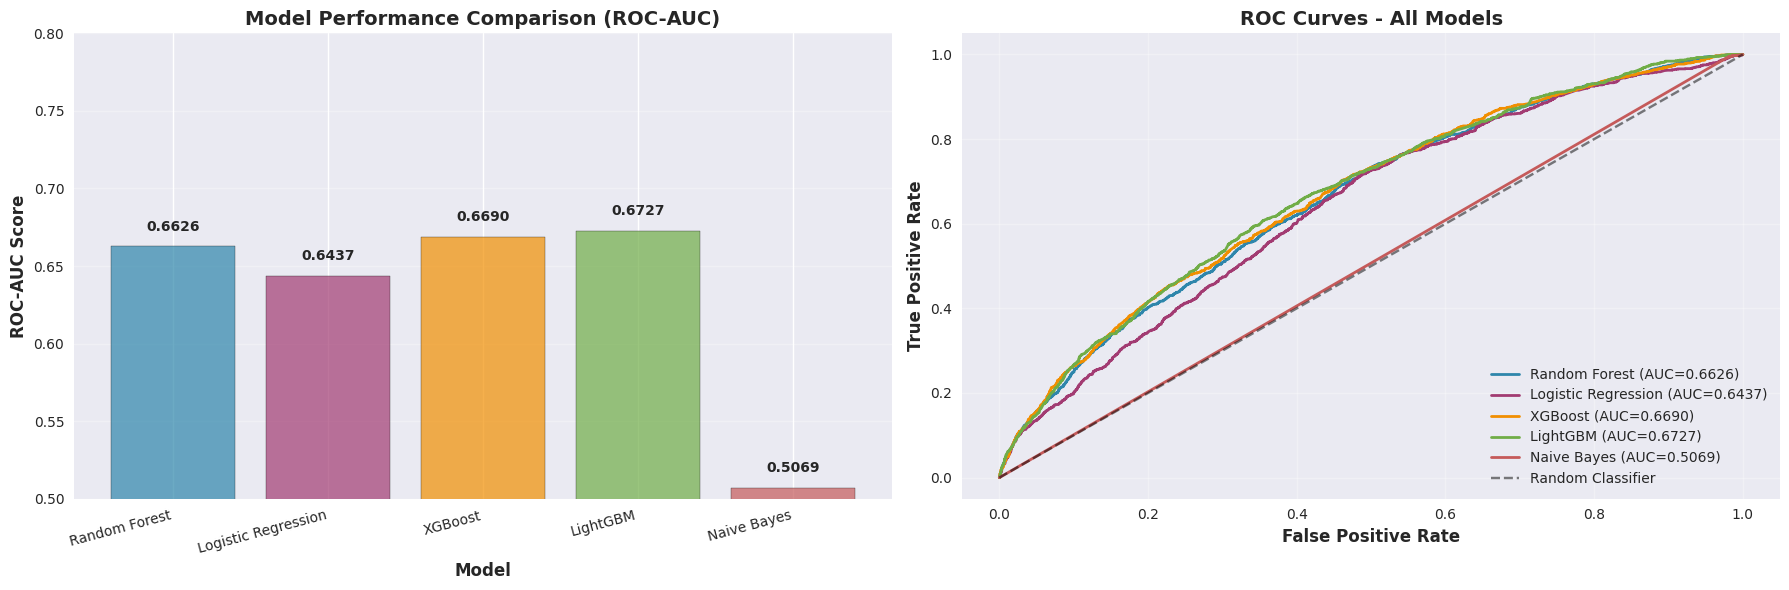

MODEL PERFORMANCE RANKING:
1. LightGBM             - ROC-AUC: 0.6727
2. XGBoost              - ROC-AUC: 0.6690
3. Random Forest        - ROC-AUC: 0.6626
4. Logistic Regression  - ROC-AUC: 0.6437
5. Naive Bayes          - ROC-AUC: 0.5069


In [39]:
# Comprehensive model comparison
all_models = {
    'Random Forest': {'roc_auc': roc_auc, 'predictions': y_pred_proba},
    'Logistic Regression': {'roc_auc': roc_auc_lr, 'predictions': y_pred_proba_lr},
    'XGBoost': {'roc_auc': roc_auc_xgb, 'predictions': y_pred_proba_xgb},
    'LightGBM': {'roc_auc': roc_auc_lgb, 'predictions': y_pred_proba_lgb},
    'Naive Bayes': {'roc_auc': roc_auc_nb, 'predictions': y_pred_proba_nb}
}

# Create comprehensive comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Model Performance Comparison
model_names = list(all_models.keys())
model_scores = [all_models[m]['roc_auc'] for m in model_names]

colors = ['#2E86AB', '#A23B72', '#F18F01', '#70AD47', '#C55A5A']
bars = axes[0].bar(range(len(model_names)), model_scores, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
axes[0].set_title('Model Performance Comparison (ROC-AUC)', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(len(model_names)))
axes[0].set_xticklabels(model_names, rotation=15, ha='right')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0.5, 0.8])

# Add value labels
for i, (bar, score) in enumerate(zip(bars, model_scores)):
    axes[0].text(i, score + 0.01, f'{score:.4f}', ha='center', fontweight='bold')

# Plot 2: ROC Curves for All Models
for model_name, color in zip(model_names, colors):
    fpr, tpr, _ = roc_curve(y_test, all_models[model_name]['predictions'])
    axes[1].plot(fpr, tpr, label=f'{model_name} (AUC={all_models[model_name]["roc_auc"]:.4f})', 
                linewidth=2, color=color)

axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
axes[1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_title('ROC Curves - All Models', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print ranking
print("MODEL PERFORMANCE RANKING:")
print("=" * 80)
ranked_models = sorted(all_models.items(), key=lambda x: x[1]['roc_auc'], reverse=True)
for rank, (model, metrics) in enumerate(ranked_models, 1):
    print(f"{rank}. {model:20s} - ROC-AUC: {metrics['roc_auc']:.4f}")
print("=" * 80)

### Hyperparameter Tuning: Random Forest with RandomizedSearchCV

In [40]:
# Random Forest parameter distributions for RandomizedSearchCV
rf_param_dist = {
	'n_estimators': randint(50, 300),
	'max_depth': [8, 10, 12, 15, None],
	'min_samples_split': randint(2, 20),
	'min_samples_leaf': randint(1, 10),
	'max_features': ['sqrt', 'log2', None],
}

print("Random Forest Hyperparameter Tuning with RandomizedSearchCV:")
print("=" * 80)

# Initialize RandomizedSearchCV
rf_random = RandomizedSearchCV(
	RandomForestClassifier(random_state=42, n_jobs=-1),
	param_distributions=rf_param_dist,
	n_iter=50,  # Try 50 random combinations
	cv=3,
	scoring='roc_auc',
	random_state=42,
	n_jobs=-1,
	verbose=1
)

# Fit
print("\nStarting RandomizedSearchCV for Random Forest (50 iterations)...")
start_time = time.time()
rf_random.fit(X_train, y_train)
end_time = time.time()

print(f"\nRandomizedSearchCV completed in {(end_time - start_time)/60:.2f} minutes")
print(f"\nBest Parameters:")
for param, value in rf_random.best_params_.items():
	print(f"  {param}: {value}")
print(f"\nBest CV ROC-AUC Score: {rf_random.best_score_:.4f}")

# Evaluate on test set
rf_best = rf_random.best_estimator_
y_pred_proba_rf_best = rf_best.predict_proba(X_test)[:, 1]
roc_auc_rf_best = roc_auc_score(y_test, y_pred_proba_rf_best)
print(f"Test ROC-AUC Score: {roc_auc_rf_best:.4f}")
print(f"Improvement over baseline: {roc_auc_rf_best - roc_auc:+.4f}")
print("=" * 80)


Random Forest Hyperparameter Tuning with RandomizedSearchCV:

Starting RandomizedSearchCV for Random Forest (50 iterations)...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

RandomizedSearchCV completed in 6.52 minutes

Best Parameters:
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 7
  min_samples_split: 10
  n_estimators: 121

Best CV ROC-AUC Score: 0.6696
Test ROC-AUC Score: 0.6657
Improvement over baseline: +0.0031


### Hyperparameter Tuning: XGBoost with RandomizedSearchCV

In [41]:
# XGBoost parameter distributions for RandomizedSearchCV
xgb_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5)
}

print("XGBoost Hyperparameter Tuning with RandomizedSearchCV:")
print("=" * 80)

# Initialize RandomizedSearchCV
xgb_random = RandomizedSearchCV(
    xgb.XGBClassifier(
        scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(),
        random_state=42,
        n_jobs=-1,
        eval_metric='auc'
    ),
    param_distributions=xgb_param_dist,
    n_iter=50,  # Try 50 random combinations
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit
print("\nStarting RandomizedSearchCV for XGBoost (50 iterations)...")
start_time = time.time()
xgb_random.fit(X_train, y_train)
end_time = time.time()

print(f"\nRandomizedSearchCV completed in {(end_time - start_time)/60:.2f} minutes")
print(f"\nBest Parameters:")
for param, value in xgb_random.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV ROC-AUC Score: {xgb_random.best_score_:.4f}")

# Evaluate on test set
xgb_best = xgb_random.best_estimator_
y_pred_proba_xgb_best = xgb_best.predict_proba(X_test)[:, 1]
roc_auc_xgb_best = roc_auc_score(y_test, y_pred_proba_xgb_best)
print(f"Test ROC-AUC Score: {roc_auc_xgb_best:.4f}")
print(f"Improvement: {roc_auc_xgb_best - roc_auc_xgb:+.4f}")
print("=" * 80)

XGBoost Hyperparameter Tuning with RandomizedSearchCV:

Starting RandomizedSearchCV for XGBoost (50 iterations)...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

RandomizedSearchCV completed in 1.83 minutes

Best Parameters:
  colsample_bytree: 0.9022204554172195
  gamma: 0.11439908274581123
  learning_rate: 0.0330939729486379
  max_depth: 5
  min_child_weight: 3
  n_estimators: 185
  subsample: 0.9521871356061031

Best CV ROC-AUC Score: 0.6722
Test ROC-AUC Score: 0.6706
Improvement: +0.0016


### Tuning Results Analysis

In [42]:
# Compare all models
comparison_df = pd.DataFrame({
    'Model': ['Baseline Random Forest', 'Optimized Random Forest', 'Optimized XGBoost'],
    'ROC-AUC': [f"{roc_auc:.4f}", f"{roc_auc_rf_best:.4f}", f"{roc_auc_xgb_best:.4f}"]
})

print("\nMODEL PERFORMANCE COMPARISON:")
display(comparison_df.set_index('Model'))


MODEL PERFORMANCE COMPARISON:


,ROC-AUC
Model,
Baseline Random Forest,0.6626
Optimized Random Forest,0.6657
Optimized XGBoost,0.6706


## 6 Neural Network Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

2025-10-07 14:27:58.582947: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-07 14:28:00.378290: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-07 14:28:06.454162: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TensorFlow version: 2.20.0
GPU Available: []


2025-10-07 14:28:07.944380: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
X_train_nn = scaler.transform(X_train)
X_test_nn = scaler.transform(X_test)

print(f"Training data shape: {X_train_nn.shape}")
print(f"Test data shape: {X_test_nn.shape}")
print(f"Number of features: {X_train_nn.shape[1]}")

Training data shape: (40000, 52)
Test data shape: (10000, 52)
Number of features: 52


### Build Neural Network Architecture

In [45]:
# Build the Neural Network model
def build_neural_network(input_dim):
    model = Sequential([
        # Input layer
        Dense(128, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),
        
        # Hidden layer 1
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Hidden layer 2
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

# Create the model
nn_model = build_neural_network(X_train_nn.shape[1])

# Display model architecture
print("Neural Network Architecture:")
print("=" * 80)
nn_model.summary()
print("=" * 80)

Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         6,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 17,601 (68.75 KB)

 Non-trainable params: 448 (1.75 KB)

### Train Neural Network

In [46]:
# Setup early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=10,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

# Train the model
print("Training Neural Network...")
print("This may take a few minutes...")
import time
start_time = time.time()

history = nn_model.fit(
    X_train_nn, y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

Training Neural Network...
This may take a few minutes...
Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.6558 - auc: 0.5478 - loss: 0.6724 - val_accuracy: 0.8444 - val_auc: 0.6562 - val_loss: 0.4688
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7992 - auc: 0.5820 - loss: 0.5065 - val_accuracy: 0.8449 - val_auc: 0.6642 - val_loss: 0.4177
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8173 - auc: 0.6038 - loss: 0.4729 - val_accuracy: 0.8444 - val_auc: 0.6699 - val_loss: 0.4112
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8192 - auc: 0.6161 - loss: 0.4637 - val_accuracy: 0.8444 - val_auc: 0.6733 - val_loss: 0.4086
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8199 - auc: 0.6269 - loss: 0.4592 - val_accuracy: 0.8444 - val_auc: 0.6750 - val_loss: 0.4090
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8213 - auc: 0.6320 - loss: 0.4555 - val_accuracy: 0.8444 - val_auc:

### Evaluate Neural Network Performance

In [47]:
# Evaluate on test set
test_loss, test_accuracy, test_auc = nn_model.evaluate(X_test_nn, y_test, verbose=0)

# Make predictions
y_pred_nn_proba = nn_model.predict(X_test_nn, verbose=0).flatten()
y_pred_nn = (y_pred_nn_proba > 0.5).astype(int)

# Calculate metrics
roc_auc_nn = roc_auc_score(y_test, y_pred_nn_proba)
cm_nn = confusion_matrix(y_test, y_pred_nn)

print("NEURAL NETWORK PERFORMANCE")
print("=" * 80)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC-AUC: {roc_auc_nn:.4f}")
print("=" * 80)

NEURAL NETWORK PERFORMANCE
Test Loss: 0.4152
Test Accuracy: 0.8416
Test ROC-AUC: 0.6579


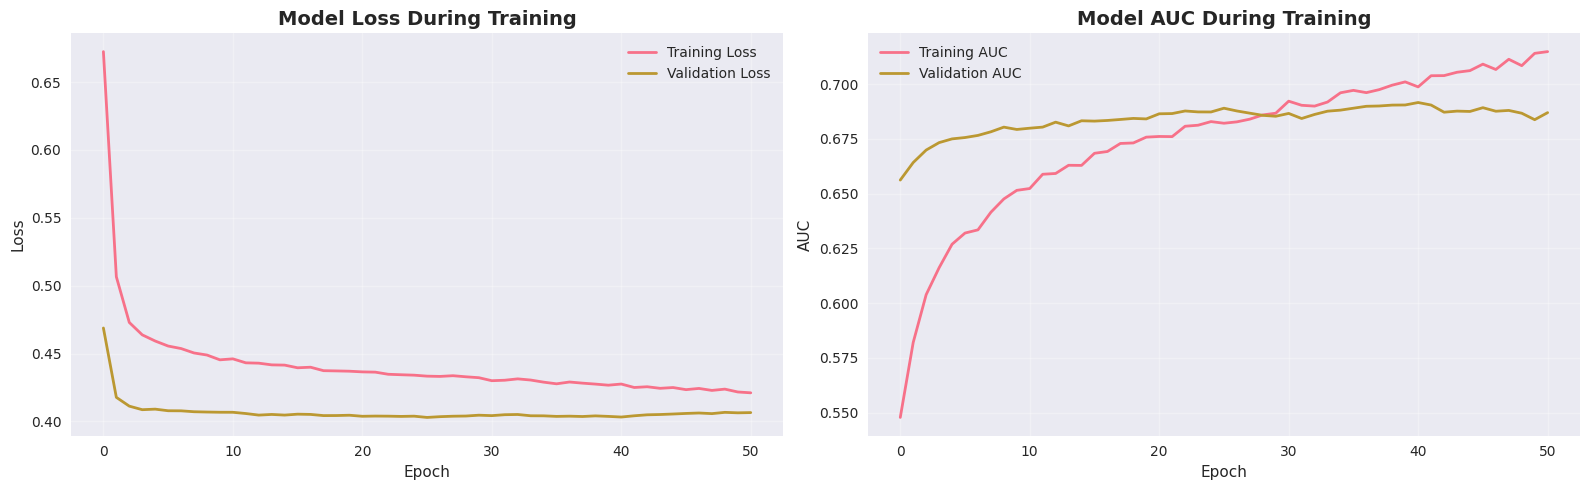


Best Validation AUC: 0.6916
Final Test AUC: 0.6579


In [48]:
# Visualize training history
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss During Training', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot AUC
axes[1].plot(history.history['auc'], label='Training AUC', linewidth=2)
axes[1].plot(history.history['val_auc'], label='Validation AUC', linewidth=2)
axes[1].set_title('Model AUC During Training', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest Validation AUC: {max(history.history['val_auc']):.4f}")
print(f"Final Test AUC: {roc_auc_nn:.4f}")

In [53]:
# Compare all models including Neural Network
comparison_final_df = pd.DataFrame({
    'Model': ['Baseline Random Forest', 'Optimized Random Forest', 'Optimized XGBoost', 'Logistic Regression', 'LightGBM', 'Neural Network'],
    'ROC-AUC': [f"{roc_auc:.4f}", f"{roc_auc_rf_best:.4f}", f"{roc_auc_xgb_best:.4f}", f"{roc_auc_lr:.4f}", f"{roc_auc_lgb:.4f}", f"{roc_auc_nn:.4f}"]
})

print("\nFINAL MODEL PERFORMANCE COMPARISON:")
print("=" * 80)
display(comparison_final_df.set_index('Model'))

# Identify best model
best_model_name = comparison_final_df.loc[comparison_final_df['ROC-AUC'].astype(float).idxmax(), 'Model']
best_score = comparison_final_df['ROC-AUC'].astype(float).max()
print(f"\nBest Performing Model: {best_model_name}")
print(f"Best ROC-AUC Score: {best_score:.4f}")


FINAL MODEL PERFORMANCE COMPARISON:


,ROC-AUC
Model,
Baseline Random Forest,0.6626
Optimized Random Forest,0.6657
Optimized XGBoost,0.6706
Logistic Regression,0.6437
LightGBM,0.6727
Neural Network,0.6579



Best Performing Model: LightGBM
Best ROC-AUC Score: 0.6727


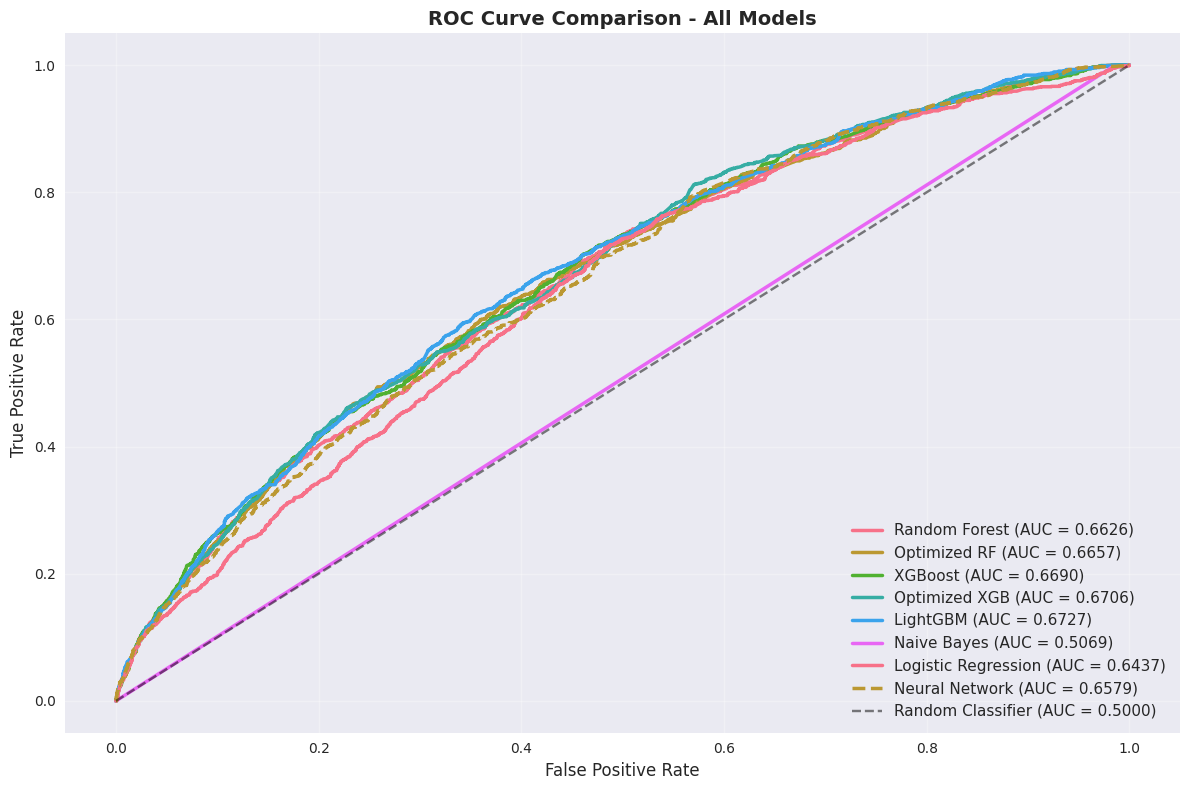

In [56]:
# Visualize ROC curves for all models
plt.figure(figsize=(12, 8))

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc:.4f})', linewidth=2.5)

# Optimized Random Forest
if 'y_pred_proba_rf_best' in locals():
    fpr_rf_best, tpr_rf_best, _ = roc_curve(y_test, y_pred_proba_rf_best)
    plt.plot(fpr_rf_best, tpr_rf_best, label=f'Optimized RF (AUC = {roc_auc_rf_best:.4f})', linewidth=2.5)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})', linewidth=2.5)

# Optimized XGBoost
if 'y_pred_proba_xgb_best' in locals():
    fpr_xgb_best, tpr_xgb_best, _ = roc_curve(y_test, y_pred_proba_xgb_best)
    plt.plot(fpr_xgb_best, tpr_xgb_best, label=f'Optimized XGB (AUC = {roc_auc_xgb_best:.4f})', linewidth=2.5)

# LightGBM
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_proba_lgb)
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {roc_auc_lgb:.4f})', linewidth=2.5)

# Naive Bayes
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_proba_nb)
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.4f})', linewidth=2.5)

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})', linewidth=2.5)

# Neural Network
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn_proba)
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_nn:.4f})', linewidth=2.5, linestyle='--')

# Random classifier baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5000)', alpha=0.5)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison - All Models', fontweight='bold', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7 Business Insights

### Time-Based Bid Optimization Strategy

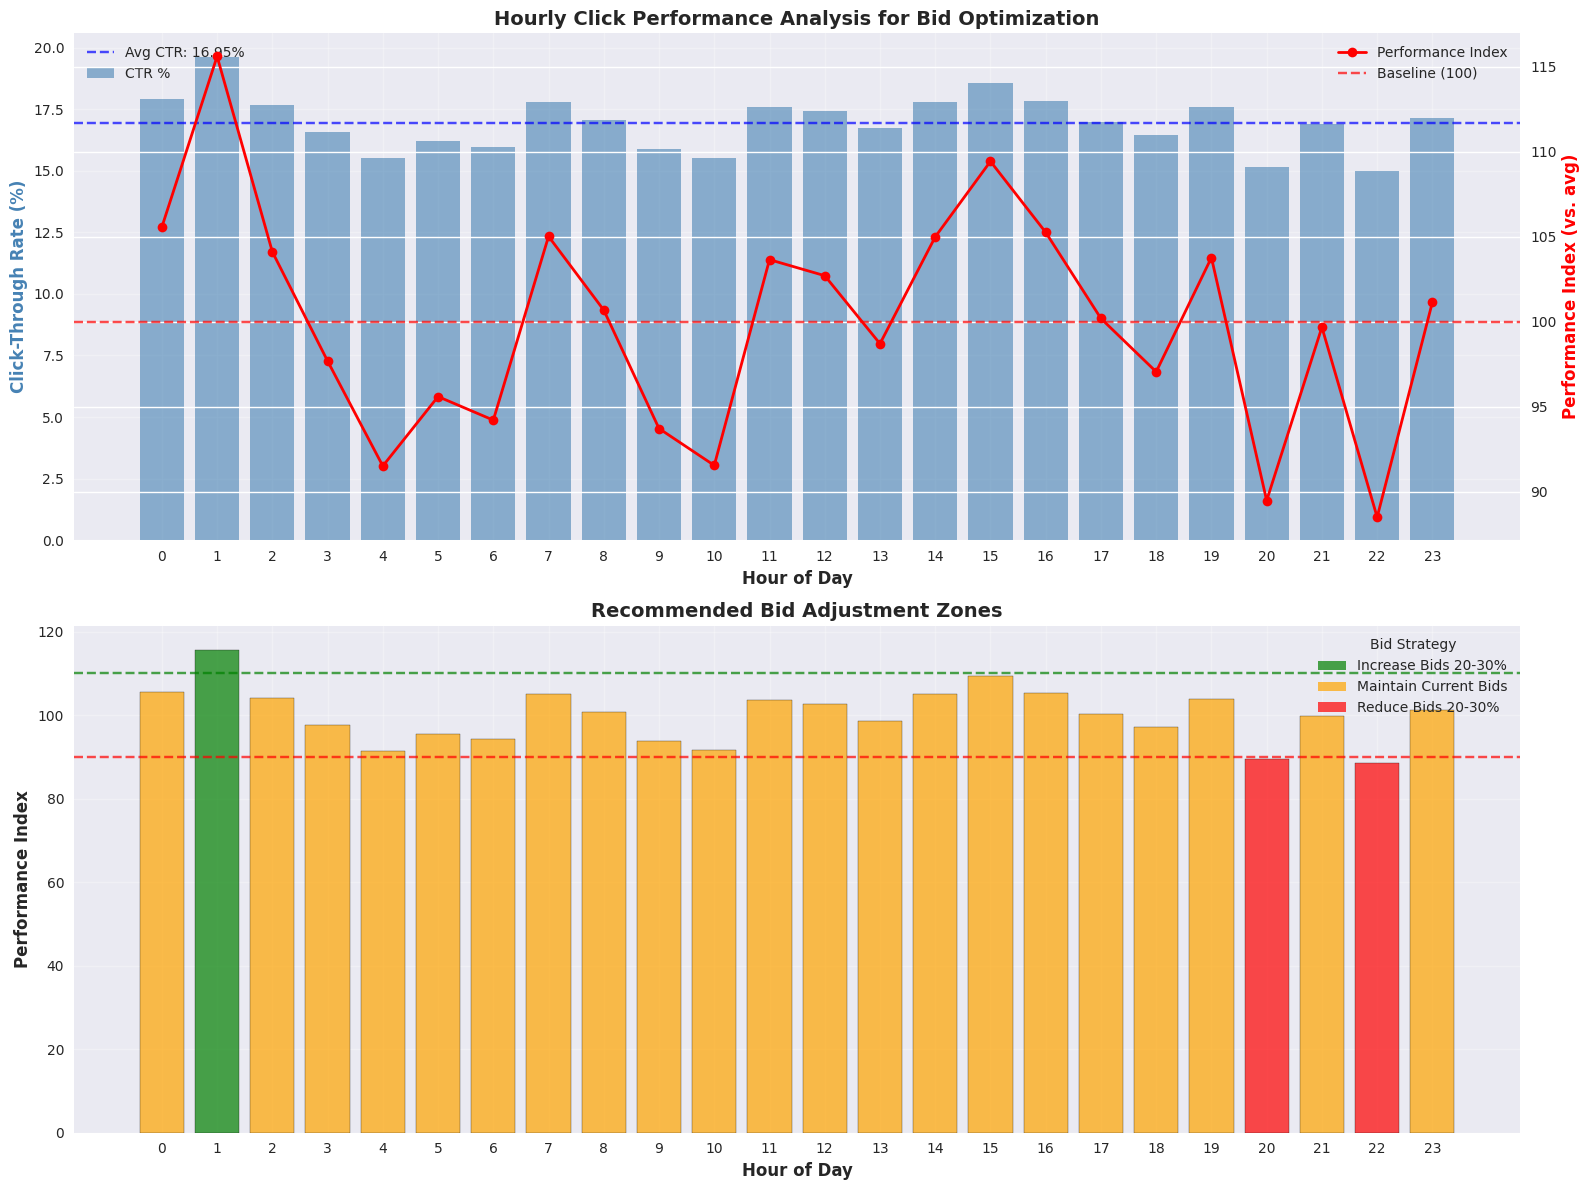

HOURLY BID OPTIMIZATION RECOMMENDATIONS:

High Performance Hours (Increase bids by 20-30%):
  • Hour 01:00 - CTR: 19.60% (Index: 116)

Low Performance Hours (Reduce bids by 20-30% or pause):
  • Hour 20:00 - CTR: 15.17% (Index: 89)
  • Hour 22:00 - CTR: 15.00% (Index: 89)

Estimated Impact:
  • Shifting 30% of budget from low to high-performing hours could increase
    overall CTR by 9.0%


In [ ]:
# Analyze CTR by hour to determine optimal bidding windows
hourly_performance = df_clean.groupby('hour_of_day').agg({
    'click': ['count', 'sum', 'mean'],
    'id': 'count'
}).reset_index()
hourly_performance.columns = ['hour', 'total_impressions', 'total_clicks', 'ctr', 'ads_count']

# Calculate performance metrics
hourly_performance['ctr_pct'] = hourly_performance['ctr'] * 100
hourly_performance['performance_index'] = (hourly_performance['ctr'] / hourly_performance['ctr'].mean()) * 100

# Categorize hours by performance
def categorize_hour(row):
    if row['performance_index'] >= 110:
        return 'High Performance (>110%)'
    elif row['performance_index'] >= 90:
        return 'Average Performance (90-110%)'
    else:
        return 'Low Performance (<90%)'

hourly_performance['category'] = hourly_performance.apply(categorize_hour, axis=1)

# Visualize hourly performance
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: CTR and Performance Index by Hour
ax1 = axes[0]
ax2 = ax1.twinx()

bars = ax1.bar(hourly_performance['hour'], hourly_performance['ctr_pct'], alpha=0.6, color='steelblue', label='CTR %')
line = ax2.plot(hourly_performance['hour'], hourly_performance['performance_index'], color='red', marker='o', linewidth=2, label='Performance Index')

ax1.axhline(y=hourly_performance['ctr_pct'].mean(), color='blue', linestyle='--', alpha=0.7, label=f'Avg CTR: {hourly_performance["ctr_pct"].mean():.2f}%')
ax2.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='Baseline (100)')

ax1.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax1.set_ylabel('Click-Through Rate (%)', fontsize=12, fontweight='bold', color='steelblue')
ax2.set_ylabel('Performance Index (vs. avg)', fontsize=12, fontweight='bold', color='red')
ax1.set_title('Hourly Click Performance Analysis for Bid Optimization', fontsize=14, fontweight='bold')
ax1.set_xticks(range(24))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Bid Recommendations
ax3 = axes[1]
colors_map = {'High Performance (>110%)': 'green', 
              'Average Performance (90-110%)': 'orange', 
              'Low Performance (<90%)': 'red'}
bar_colors = hourly_performance['category'].map(colors_map)

ax3.bar(hourly_performance['hour'], hourly_performance['performance_index'], color=bar_colors, alpha=0.7, edgecolor='black')
ax3.axhline(y=110, color='green', linestyle='--', alpha=0.7, label='High Performance Threshold')
ax3.axhline(y=90, color='red', linestyle='--', alpha=0.7, label='Low Performance Threshold')
ax3.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax3.set_ylabel('Performance Index', fontsize=12, fontweight='bold')
ax3.set_title('Recommended Bid Adjustment Zones', fontsize=14, fontweight='bold')
ax3.set_xticks(range(24))
ax3.legend()
ax3.grid(True, alpha=0.3)

# Add color legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', alpha=0.7, label='Increase Bids 20-30%'),
                   Patch(facecolor='orange', alpha=0.7, label='Maintain Current Bids'),
                   Patch(facecolor='red', alpha=0.7, label='Reduce Bids 20-30%')]
ax3.legend(handles=legend_elements, loc='upper right', title='Bid Strategy')

plt.tight_layout()
plt.show()

# Print recommendations
print("HOURLY BID OPTIMIZATION RECOMMENDATIONS:")
print("=" * 80)
print("\nHigh Performance Hours (Increase bids by 20-30%):")
high_perf = hourly_performance[hourly_performance['category'] == 'High Performance (>110%)']
for _, row in high_perf.iterrows():
    print(f"  • Hour {int(row['hour']):02d}:00 - CTR: {row['ctr_pct']:.2f}% (Index: {row['performance_index']:.0f})")

print("\nLow Performance Hours (Reduce bids by 20-30% or pause):")
low_perf = hourly_performance[hourly_performance['category'] == 'Low Performance (<90%)']
for _, row in low_perf.iterrows():
    print(f"  • Hour {int(row['hour']):02d}:00 - CTR: {row['ctr_pct']:.2f}% (Index: {row['performance_index']:.0f})")

print("\nEstimated Impact:")
print(f"  • Shifting 30% of budget from low to high-performing hours could increase")
print(f"    overall CTR by {((high_perf['ctr'].mean() / low_perf['ctr'].mean()) - 1) * 30:.1f}%")
print("=" * 80)

### Device and Placement Optimization Policy

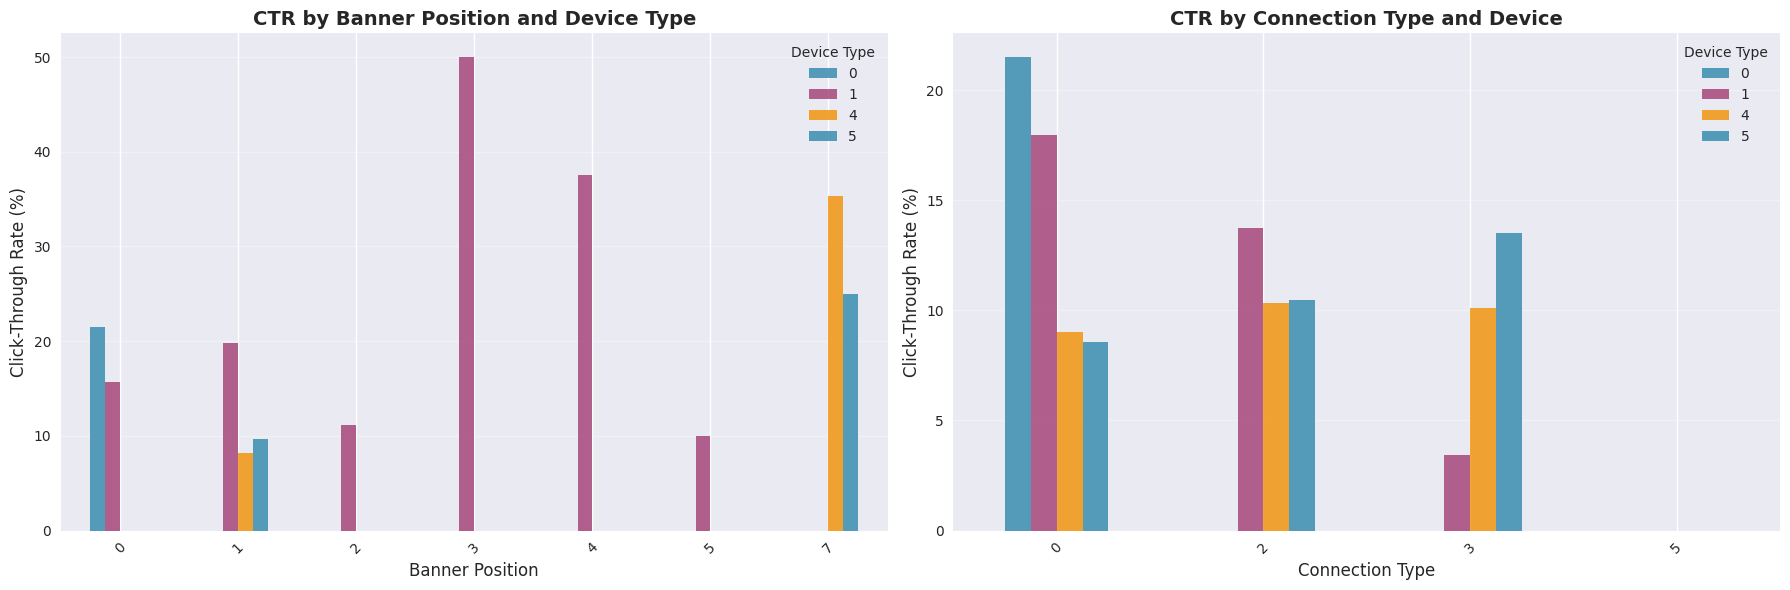

DEVICE AND PLACEMENT OPTIMIZATION POLICY:

Top 5 Device-Banner Combinations (prioritize these):
  • Device 1.0, Banner Position 3.0: 50.00% CTR (2 impressions)
  • Device 1.0, Banner Position 4.0: 37.50% CTR (8 impressions)
  • Device 4.0, Banner Position 7.0: 35.29% CTR (51 impressions)
  • Device 5.0, Banner Position 7.0: 25.00% CTR (8 impressions)
  • Device 0.0, Banner Position 0.0: 21.50% CTR (2730 impressions)

Bottom 5 Device-Banner Combinations (reduce/avoid):
  • Device 4.0, Banner Position 0.0: 0.00% CTR (1 impressions)
  • Device 4.0, Banner Position 1.0: 8.23% CTR (875 impressions)
  • Device 5.0, Banner Position 1.0: 9.64% CTR (166 impressions)
  • Device 1.0, Banner Position 5.0: 10.00% CTR (10 impressions)
  • Device 1.0, Banner Position 2.0: 11.11% CTR (9 impressions)

Top Connection-Device Combinations:
  • Device 0.0, Connection 0.0: 21.50% CTR
  • Device 1.0, Connection 0.0: 17.96% CTR
  • Device 1.0, Connection 2.0: 13.73% CTR

Actionable Recommendations:
  1. Incre

In [58]:
# Analyze performance by device type, banner position, and connection type
device_banner_analysis = df_clean.groupby(['device_type', 'banner_pos']).agg({
    'click': ['count', 'sum', 'mean']
}).reset_index()
device_banner_analysis.columns = ['device_type', 'banner_pos', 'impressions', 'clicks', 'ctr']
device_banner_analysis['ctr_pct'] = device_banner_analysis['ctr'] * 100

# Device and connection analysis
device_conn_perf = df_clean.groupby(['device_type', 'device_conn_type']).agg({
    'click': ['count', 'sum', 'mean']
}).reset_index()
device_conn_perf.columns = ['device_type', 'device_conn_type', 'impressions', 'clicks', 'ctr']
device_conn_perf['ctr_pct'] = device_conn_perf['ctr'] * 100

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Banner Position Performance by Device
pivot_banner = device_banner_analysis.pivot(index='banner_pos', columns='device_type', values='ctr_pct')
pivot_banner.plot(kind='bar', ax=axes[0], color=['#2E86AB', '#A23B72', '#F18F01'], alpha=0.8)
axes[0].set_title('CTR by Banner Position and Device Type', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Banner Position', fontsize=12)
axes[0].set_ylabel('Click-Through Rate (%)', fontsize=12)
axes[0].legend(title='Device Type')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Connection Type Performance by Device
pivot_conn = device_conn_perf.pivot(index='device_conn_type', columns='device_type', values='ctr_pct')
pivot_conn.plot(kind='bar', ax=axes[1], color=['#2E86AB', '#A23B72', '#F18F01'], alpha=0.8)
axes[1].set_title('CTR by Connection Type and Device', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Connection Type', fontsize=12)
axes[1].set_ylabel('Click-Through Rate (%)', fontsize=12)
axes[1].legend(title='Device Type')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Generate placement policy recommendations
print("DEVICE AND PLACEMENT OPTIMIZATION POLICY:")
print("=" * 80)

# Find best performing combinations
best_combos = device_banner_analysis.nlargest(5, 'ctr_pct')
print("\nTop 5 Device-Banner Combinations (prioritize these):")
for idx, row in best_combos.iterrows():
    print(f"  • Device {row['device_type']}, Banner Position {row['banner_pos']}: "
          f"{row['ctr_pct']:.2f}% CTR ({row['impressions']:.0f} impressions)")

worst_combos = device_banner_analysis.nsmallest(5, 'ctr_pct')
print("\nBottom 5 Device-Banner Combinations (reduce/avoid):")
for idx, row in worst_combos.iterrows():
    print(f"  • Device {row['device_type']}, Banner Position {row['banner_pos']}: "
          f"{row['ctr_pct']:.2f}% CTR ({row['impressions']:.0f} impressions)")

# Connection type recommendations
best_conn = device_conn_perf.nlargest(3, 'ctr_pct')
print("\nTop Connection-Device Combinations:")
for idx, row in best_conn.iterrows():
    print(f"  • Device {row['device_type']}, Connection {row['device_conn_type']}: "
          f"{row['ctr_pct']:.2f}% CTR")

print("\nActionable Recommendations:")
print("  1. Increase bids by 30-50% for top-performing device-banner combinations")
print("  2. Redirect budget from bottom 5 to top 5 combinations")
print("  3. A/B test banner creative optimization for underperforming positions")
print("  4. Consider device-specific landing pages for top-performing device types")
print("=" * 80)

### Predictive Targeting Strategy

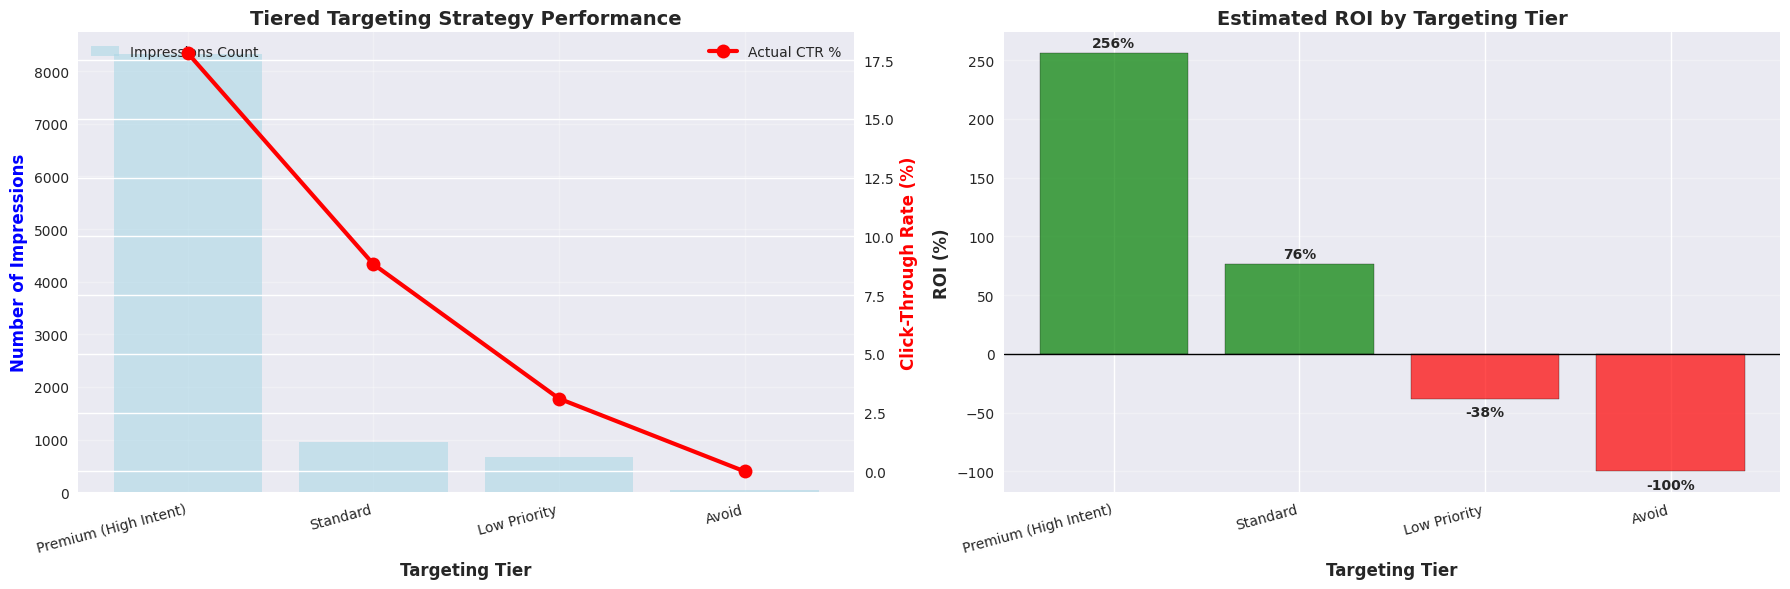

PREDICTIVE TARGETING STRATEGY RECOMMENDATIONS:

Tier Performance Summary:

Premium (High Intent):
  • Volume: 8321 impressions (83.2% of total)
  • Actual CTR: 17.80%
  • Estimated ROI: 256%

Standard:
  • Volume: 964 impressions (9.6% of total)
  • Actual CTR: 8.82%
  • Estimated ROI: 76%

Low Priority:
  • Volume: 678 impressions (6.8% of total)
  • Actual CTR: 3.10%
  • Estimated ROI: -38%

Avoid:
  • Volume: 37 impressions (0.4% of total)
  • Actual CTR: 0.00%
  • Estimated ROI: -100%

Actionable Recommendations:
  1. PREMIUM TIER: Increase bids by 50-100% to capture high-intent users
     - 17.80% CTR delivers 256% ROI
  2. AVOID TIER: Reduce bids by 70-80% or exclude entirely
     - 0.00% CTR delivers -100% ROI
  3. Reallocate $3.70 from Avoid tier to Premium tier
     - Could generate 7 additional clicks


In [ ]:
# Create probability-based segments using model predictions
tier_thresholds = {
    'Premium (High Intent)': (0.25, 1.0),
    'Standard': (0.15, 0.25),
    'Low Priority': (0.05, 0.15),
    'Avoid': (0.0, 0.05)
}

# Categorize test set predictions
def categorize_probability(prob):
    for tier, (low, high) in tier_thresholds.items():
        if low <= prob < high:
            return tier
    return 'Avoid'

y_pred_proba_series = pd.Series(y_pred_proba_lgb) # Using LightGBM predictions for segmentation
tier_assignments = y_pred_proba_series.apply(categorize_probability)

# Analyze tier performance
tier_analysis = pd.DataFrame({
    'tier': tier_assignments,
    'predicted_prob': y_pred_proba_lgb,
    'actual_click': y_test.values
})

tier_summary = tier_analysis.groupby('tier').agg({
    'predicted_prob': ['mean', 'count'],
    'actual_click': ['sum', 'mean']
}).reset_index()
tier_summary.columns = ['tier', 'avg_predicted_prob', 'count', 'actual_clicks', 'actual_ctr']
tier_summary['actual_ctr_pct'] = tier_summary['actual_ctr'] * 100

# Sort tiers logically
tier_order = ['Premium (High Intent)', 'Standard', 'Low Priority', 'Avoid']
tier_summary['tier'] = pd.Categorical(tier_summary['tier'], categories=tier_order, ordered=True)
tier_summary = tier_summary.sort_values('tier')

# Visualize tiered strategy
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Distribution and CTR by Tier
x_pos = range(len(tier_summary))
ax1 = axes[0]
ax2 = ax1.twinx()

bars = ax1.bar(x_pos, tier_summary['count'], alpha=0.6, color='lightblue', 
               label='Impressions Count')
line = ax2.plot(x_pos, tier_summary['actual_ctr_pct'], color='red', marker='o', 
                linewidth=3, markersize=10, label='Actual CTR %')

ax1.set_xlabel('Targeting Tier', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Impressions', fontsize=12, fontweight='bold', color='blue')
ax2.set_ylabel('Click-Through Rate (%)', fontsize=12, fontweight='bold', color='red')
ax1.set_title('Tiered Targeting Strategy Performance', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(tier_summary['tier'], rotation=15, ha='right')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: ROI Potential by Tier
cost_per_impression = 0.10
value_per_click = 2.00

tier_summary['cost'] = tier_summary['count'] * cost_per_impression
tier_summary['revenue'] = tier_summary['actual_clicks'] * value_per_click
tier_summary['roi'] = ((tier_summary['revenue'] - tier_summary['cost']) / tier_summary['cost']) * 100

ax3 = axes[1]
colors_roi = ['green' if roi > 0 else 'red' for roi in tier_summary['roi']]
ax3.bar(x_pos, tier_summary['roi'], color=colors_roi, alpha=0.7, edgecolor='black')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.set_xlabel('Targeting Tier', fontsize=12, fontweight='bold')
ax3.set_ylabel('ROI (%)', fontsize=12, fontweight='bold')
ax3.set_title('Estimated ROI by Targeting Tier', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(tier_summary['tier'], rotation=15, ha='right')
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(tier_summary['roi']):
    ax3.text(i, v + (5 if v > 0 else -15), f'{v:.0f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Print recommendations
print("PREDICTIVE TARGETING STRATEGY RECOMMENDATIONS:")
print("=" * 80)
print("\nTier Performance Summary:")
for _, row in tier_summary.iterrows():
    print(f"\n{row['tier']}:")
    print(f"  • Volume: {row['count']:.0f} impressions ({row['count']/tier_summary['count'].sum()*100:.1f}% of total)")
    print(f"  • Actual CTR: {row['actual_ctr_pct']:.2f}%")
    print(f"  • Estimated ROI: {row['roi']:.0f}%")

print("\nActionable Recommendations:")
premium_tier = tier_summary[tier_summary['tier'] == 'Premium (High Intent)'].iloc[0]
avoid_tier = tier_summary[tier_summary['tier'] == 'Avoid'].iloc[0]

print(f"  1. PREMIUM TIER: Increase bids by 50-100% to capture high-intent users")
print(f"     - {premium_tier['actual_ctr_pct']:.2f}% CTR delivers {premium_tier['roi']:.0f}% ROI")
print(f"  2. AVOID TIER: Reduce bids by 70-80% or exclude entirely")
print(f"     - {avoid_tier['actual_ctr_pct']:.2f}% CTR delivers {avoid_tier['roi']:.0f}% ROI")
print(f"  3. Reallocate ${avoid_tier['cost']:.2f} from Avoid tier to Premium tier")
potential_improvement = (premium_tier['actual_ctr'] - avoid_tier['actual_ctr']) * avoid_tier['count']
print(f"     - Could generate {potential_improvement:.0f} additional clicks")
print("=" * 80)